In [1]:
import pandas as pd
import numpy as np

from scipy import stats, odr

from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

# Reading Cleaned Data

In [2]:
df = pd.read_pickle('data.pkl')

In [3]:
# Data types
df.dtypes

Sex           object
Event         object
Age          float64
Tested        object
Squat        float64
Bench        float64
Dead         float64
Total        float64
Weight        object
AgeGroup    category
dtype: object

# Removing Drug Tested Competitions

Data Exploration and Statistical Testing will be first performed separately and the results will be compared at the end.


In [4]:
df = df[df['Tested']=='No'].reset_index(drop = True)

# Stratifying Strength Data

Total = Weight of all three lifts combined (must have three at one competition)

Deadlift = Weight of maximum deadlift

Bench Press = Weight of maximum bench press

Squat = Weight of maximum squat

In [5]:
total = df[(df['Event']=='SBD')&\
          (df['Total'].notnull())&(df['Total']>0)].reset_index(drop = True)[['Sex','Age','Tested','Total','Weight','AgeGroup']].copy()

dead = df[(df['Dead'].notnull())&\
         (df['Dead']>0)].reset_index(drop = True)[['Sex','Age','Tested','Dead','Weight','AgeGroup']].copy()

bench = df[(df['Bench'].notnull())&\
          (df['Bench']>0)].reset_index(drop = True)[['Sex','Age','Tested','Bench','Weight','AgeGroup']].copy()

squat = df[(df['Squat'].notnull())&\
          (df['Squat']>0)].reset_index(drop = True)[['Sex','Age','Tested','Squat','Weight','AgeGroup']].copy()

# Visualizations - Age, Weight, Strength

In [6]:
def quadrant(total,bench,squat,dead,sex,plot):
    fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))

    axs[0,0].set_title('Age and Total Weight Lifted for '+sex)
    axs[0,1].set_title('Age and Bench Press for '+sex)
    axs[1,0].set_title('Age and Squat for '+sex)
    axs[1,1].set_title('Age and Deadlift for '+sex)

    common_xlim = (min(df['Age'])-10, max(df['Age'])+20)
    
    axs[0, 0].set_xlim(common_xlim)
    axs[0, 1].set_xlim(common_xlim)
    axs[1, 0].set_xlim(common_xlim)
    axs[1, 1].set_xlim(common_xlim)
    
    if plot == 'Scatter':
        sns.scatterplot(data=total[total['Sex'] == sex].copy(), x='Age', y='Total', color='steelblue', ax=axs[0, 0])
        sns.scatterplot(data=bench[bench['Sex'] == sex].copy(), x='Age', y='Bench', color='steelblue', ax=axs[0, 1])
        sns.scatterplot(data=squat[squat['Sex'] == sex].copy(), x='Age', y='Squat', color='steelblue', ax=axs[1, 0])
        sns.scatterplot(data=dead[dead['Sex'] == sex].copy(), x='Age', y='Dead', color='steelblue', ax=axs[1, 1])
        plt.tight_layout()
    elif plot == 'Box':
        sns.boxplot(data=total[total['Sex'] == sex].copy(), x='AgeGroup', y='Total', color='steelblue', ax=axs[0, 0])
        sns.boxplot(data=bench[bench['Sex'] == sex].copy(), x='AgeGroup', y='Bench', color='steelblue', ax=axs[0, 1])
        sns.boxplot(data=squat[squat['Sex'] == sex].copy(), x='AgeGroup', y='Squat', color='steelblue', ax=axs[1, 0])
        sns.boxplot(data=dead[dead['Sex'] == sex].copy(), x='AgeGroup', y='Dead', color='steelblue', ax=axs[1, 1])
        plt.tight_layout()

Sex = M

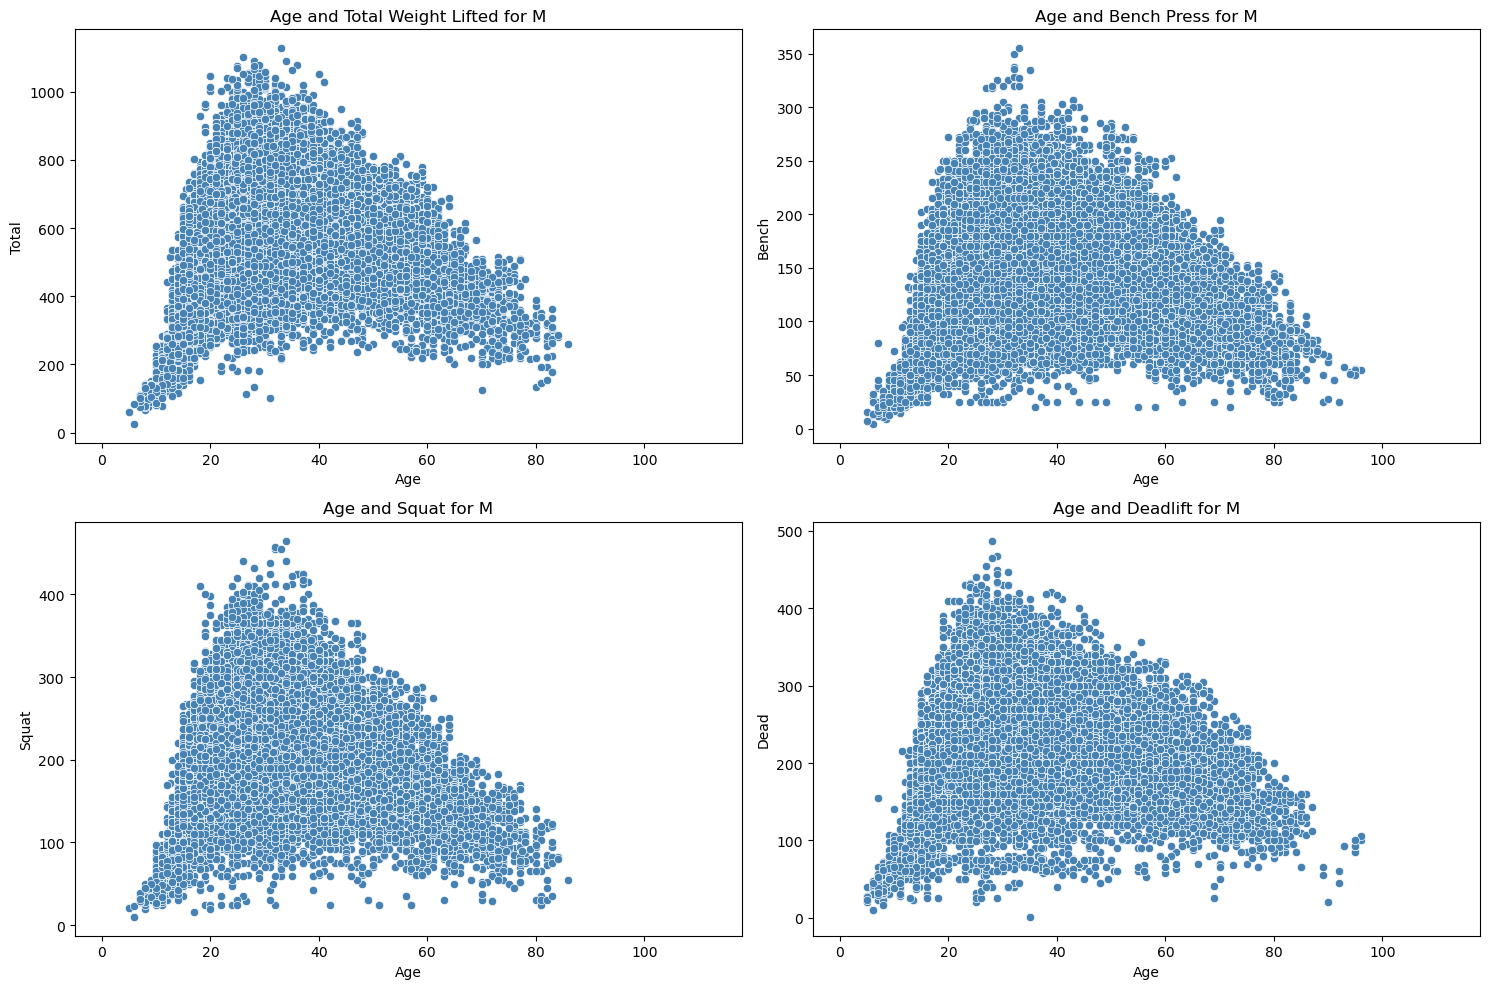

In [7]:
quadrant(total,bench,squat,dead,'M','Scatter')

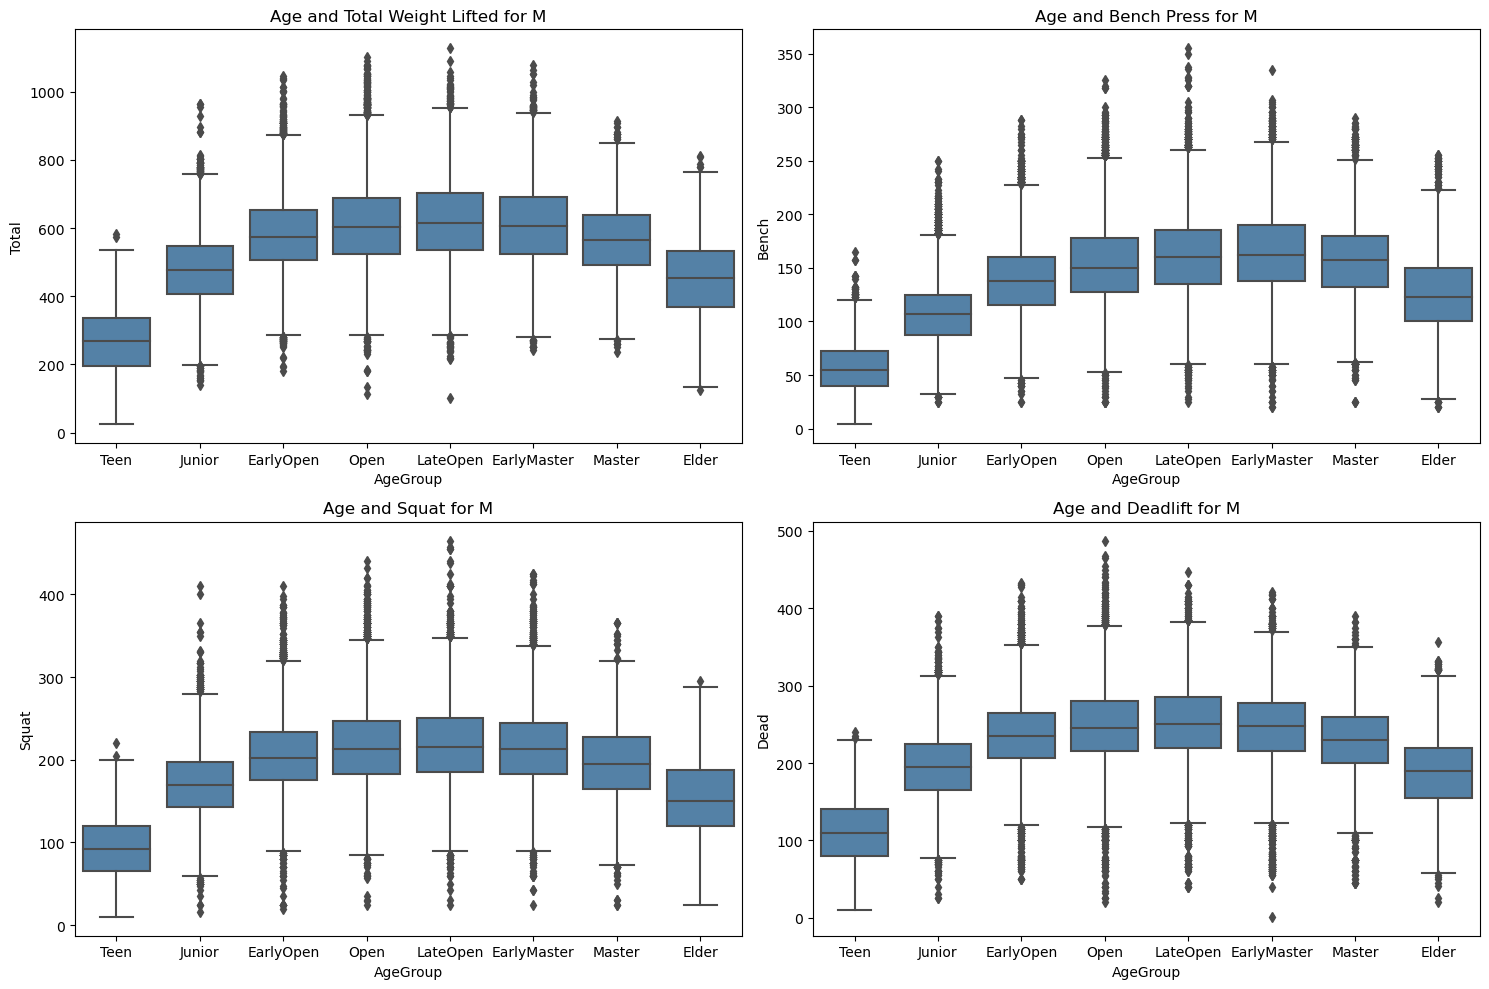

In [8]:
quadrant(total,bench,squat,dead,'M','Box')

Sex = F

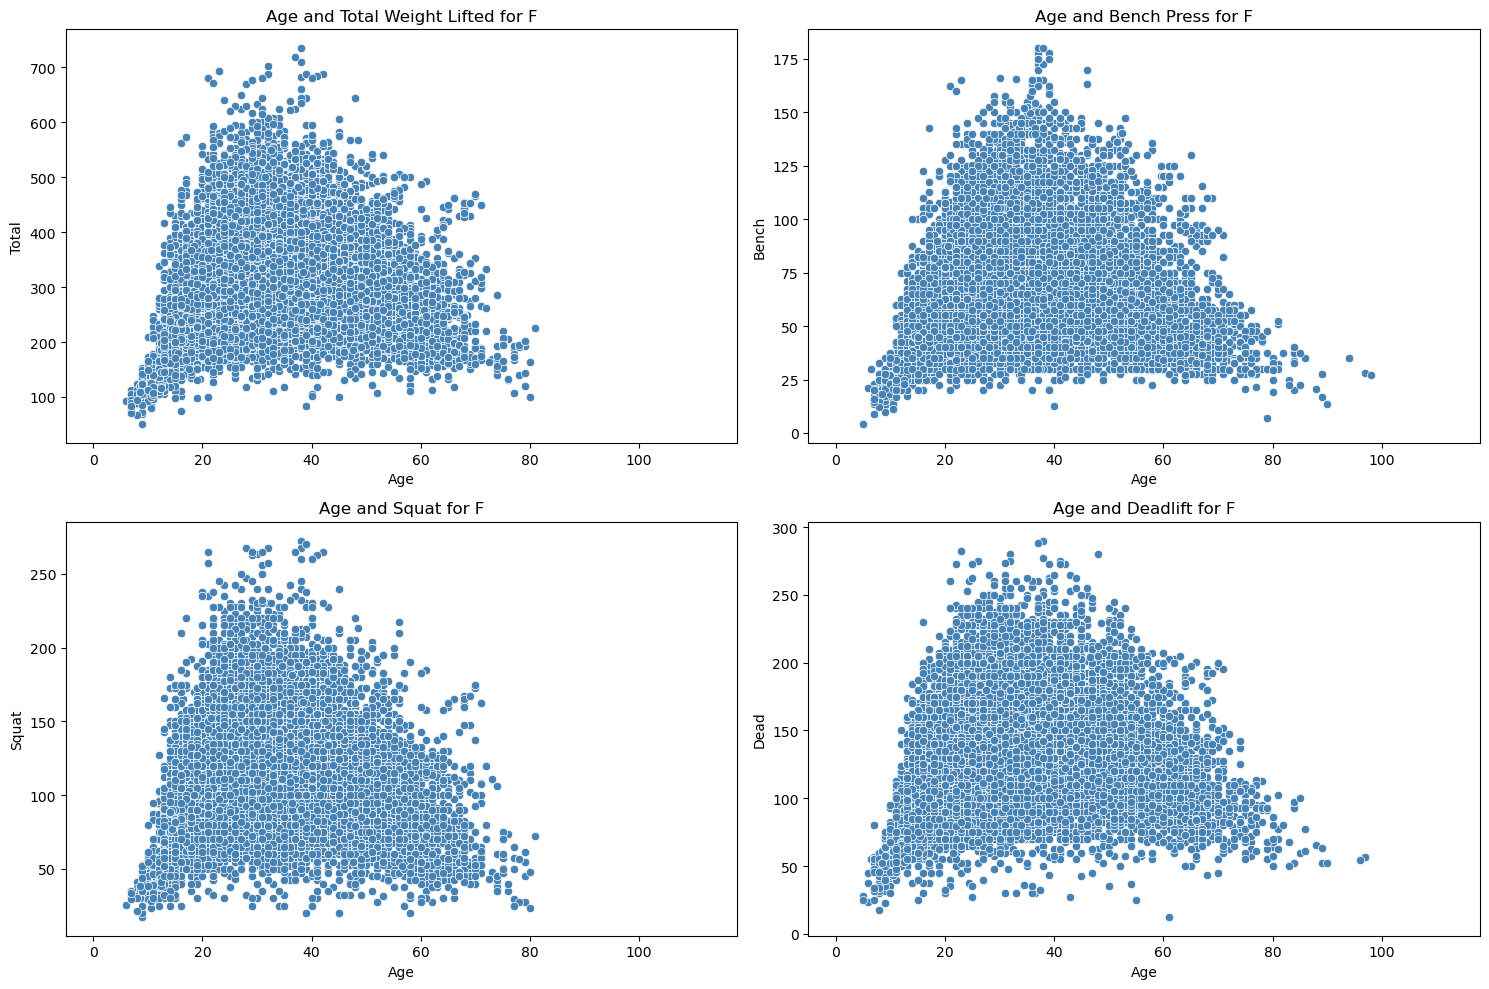

In [9]:
# Female
quadrant(total,bench,squat,dead,'F','Scatter')

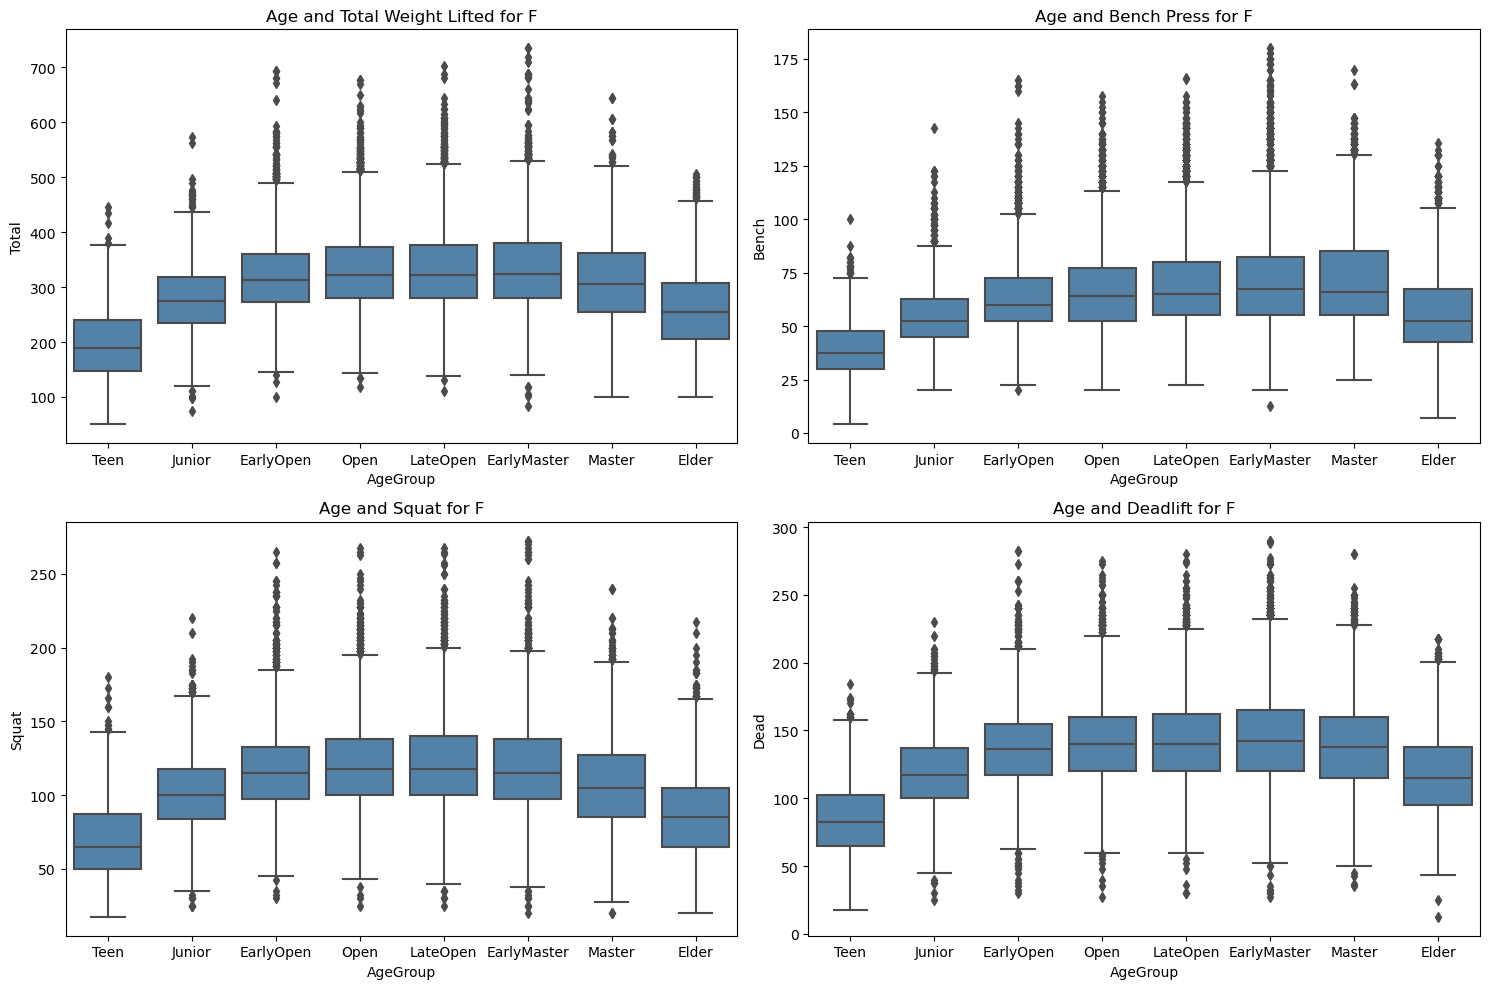

In [10]:
quadrant(total,bench,squat,dead,'F','Box')

Take a random sample for each age group

In [11]:
age_groups = df['AgeGroup'].unique()

def sample(total, n):
    dfs = pd.DataFrame()
    for x in range(len(age_groups)):
        a = total[total['AgeGroup']==age_groups[x]].copy()
        aa = a.sample(n = 500).copy()
        dfs = pd.concat([dfs,aa], axis = 0, ignore_index = True)
    return dfs

Sex = M

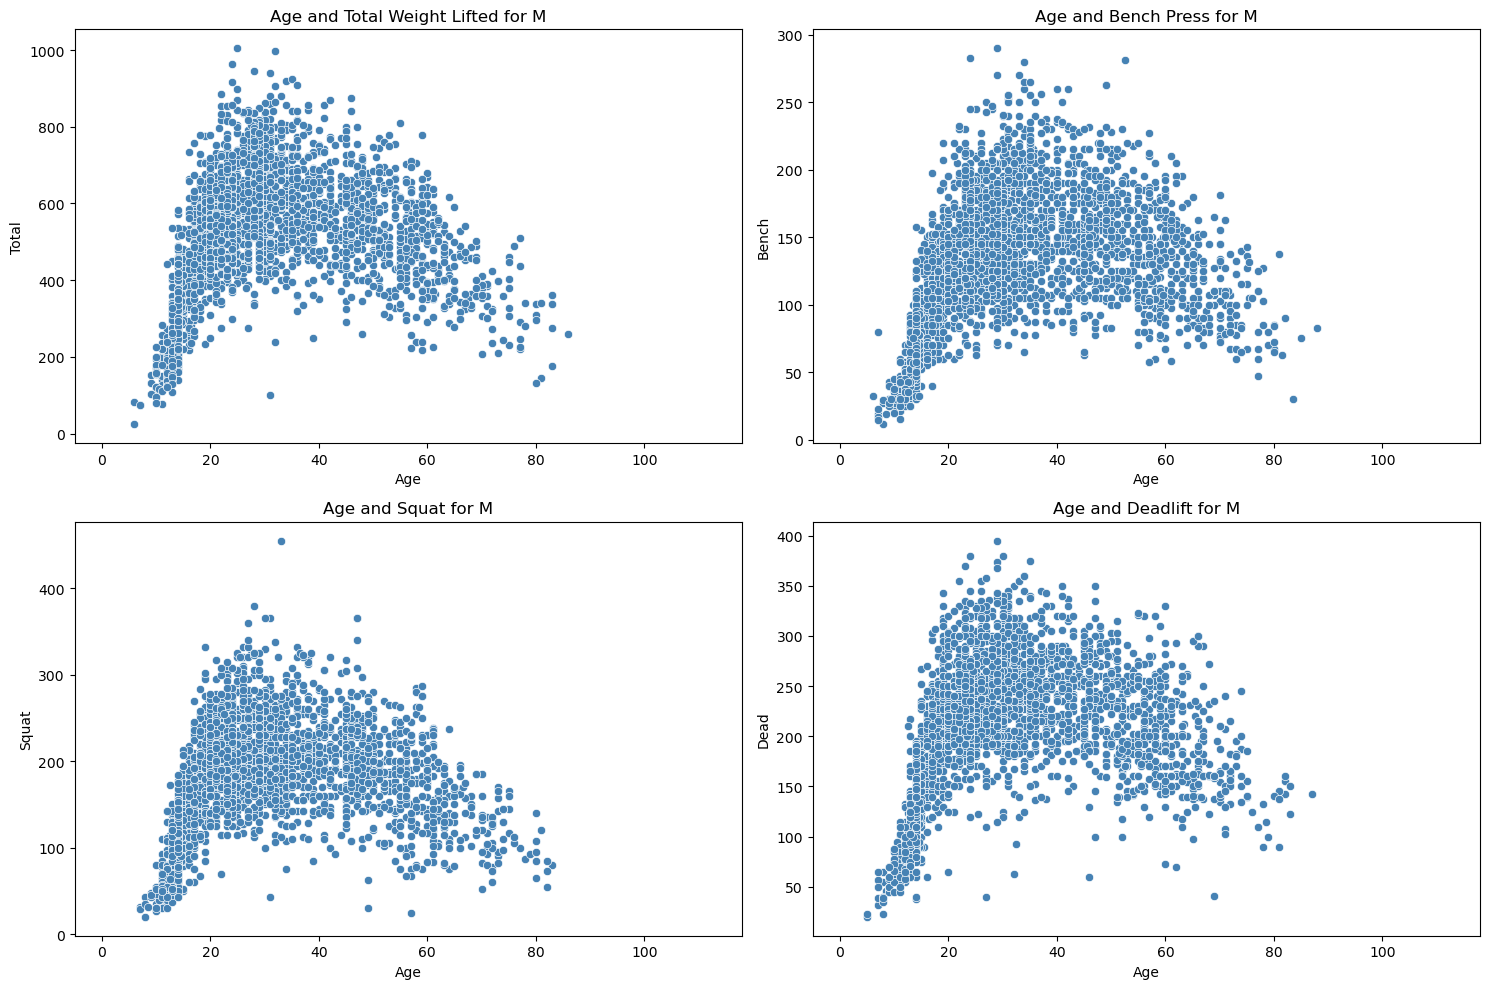

In [12]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Scatter')

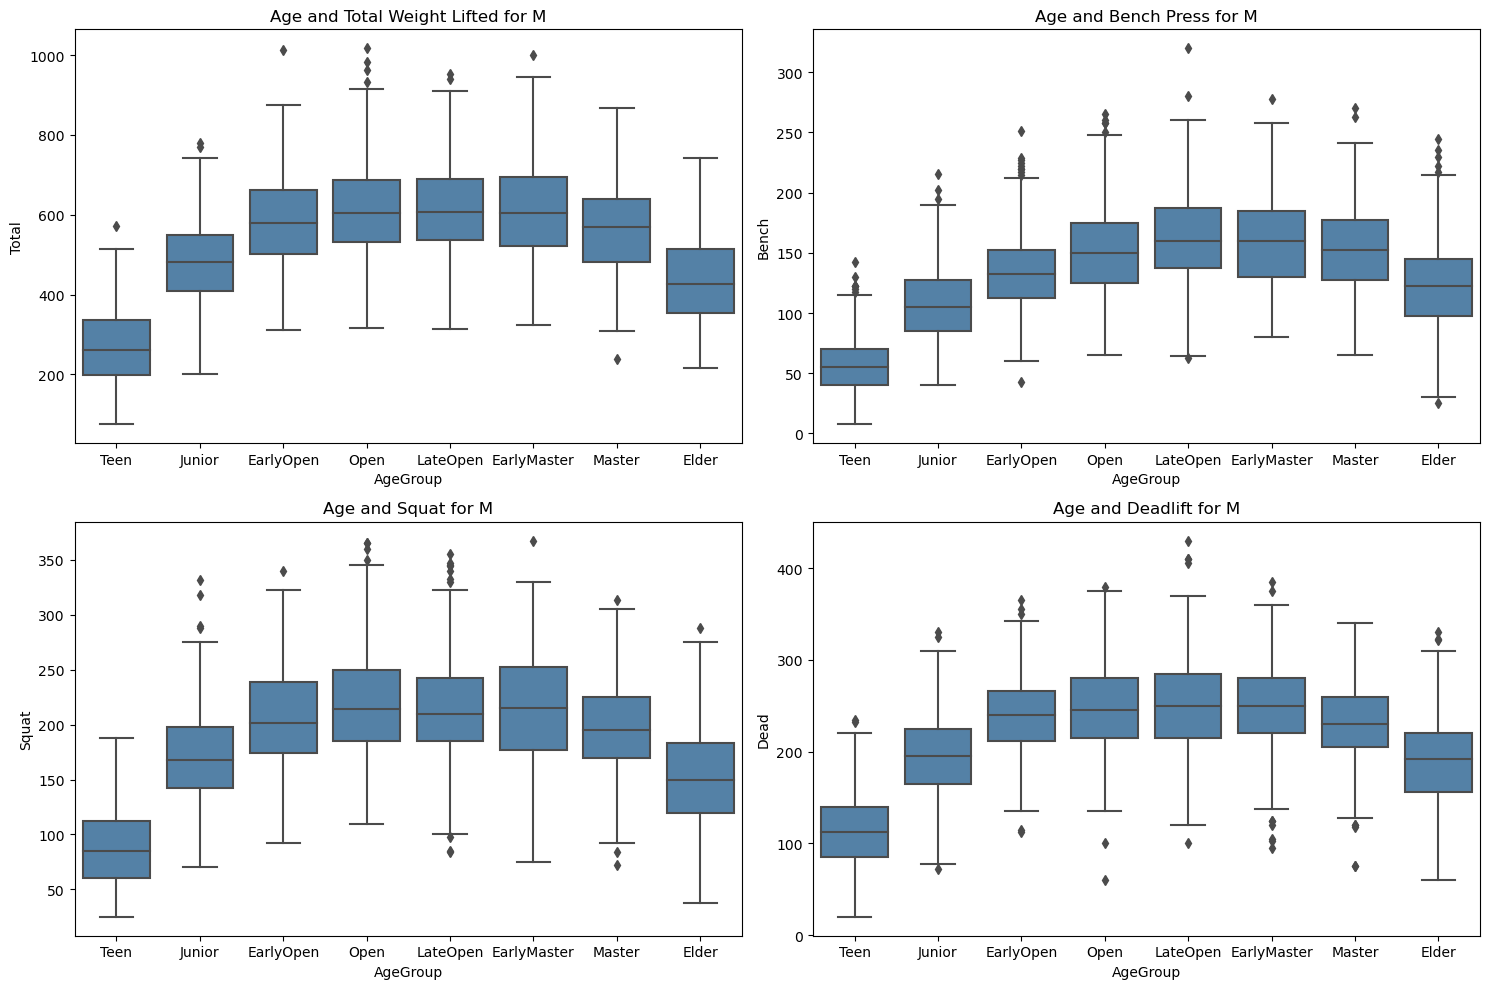

In [13]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Box')

Sex = F

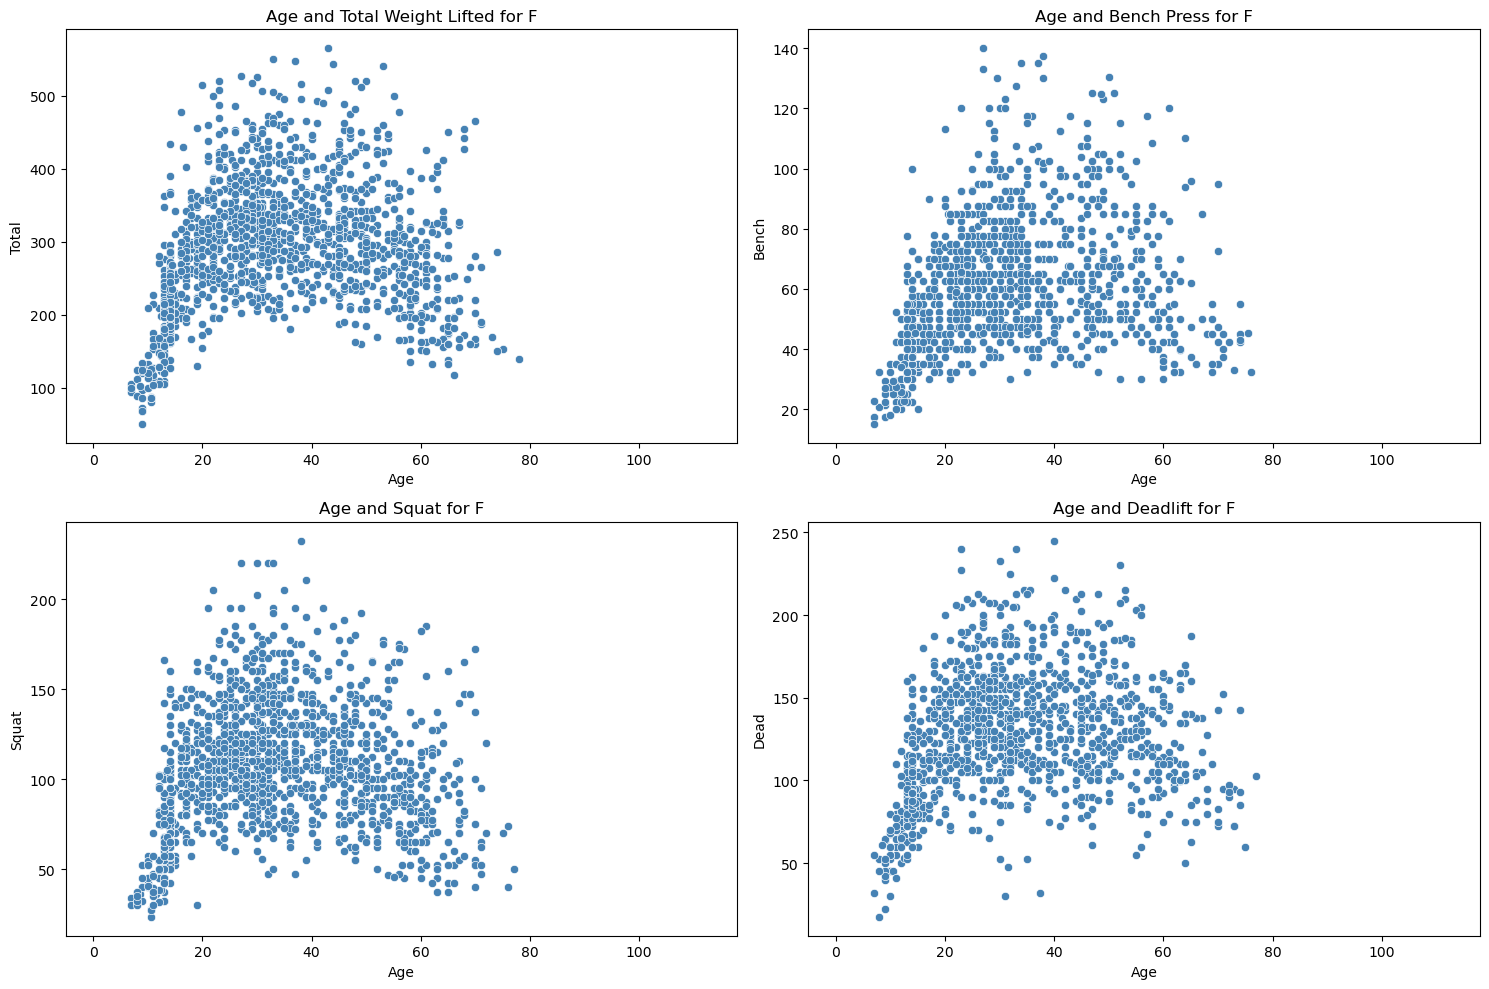

In [14]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Scatter')

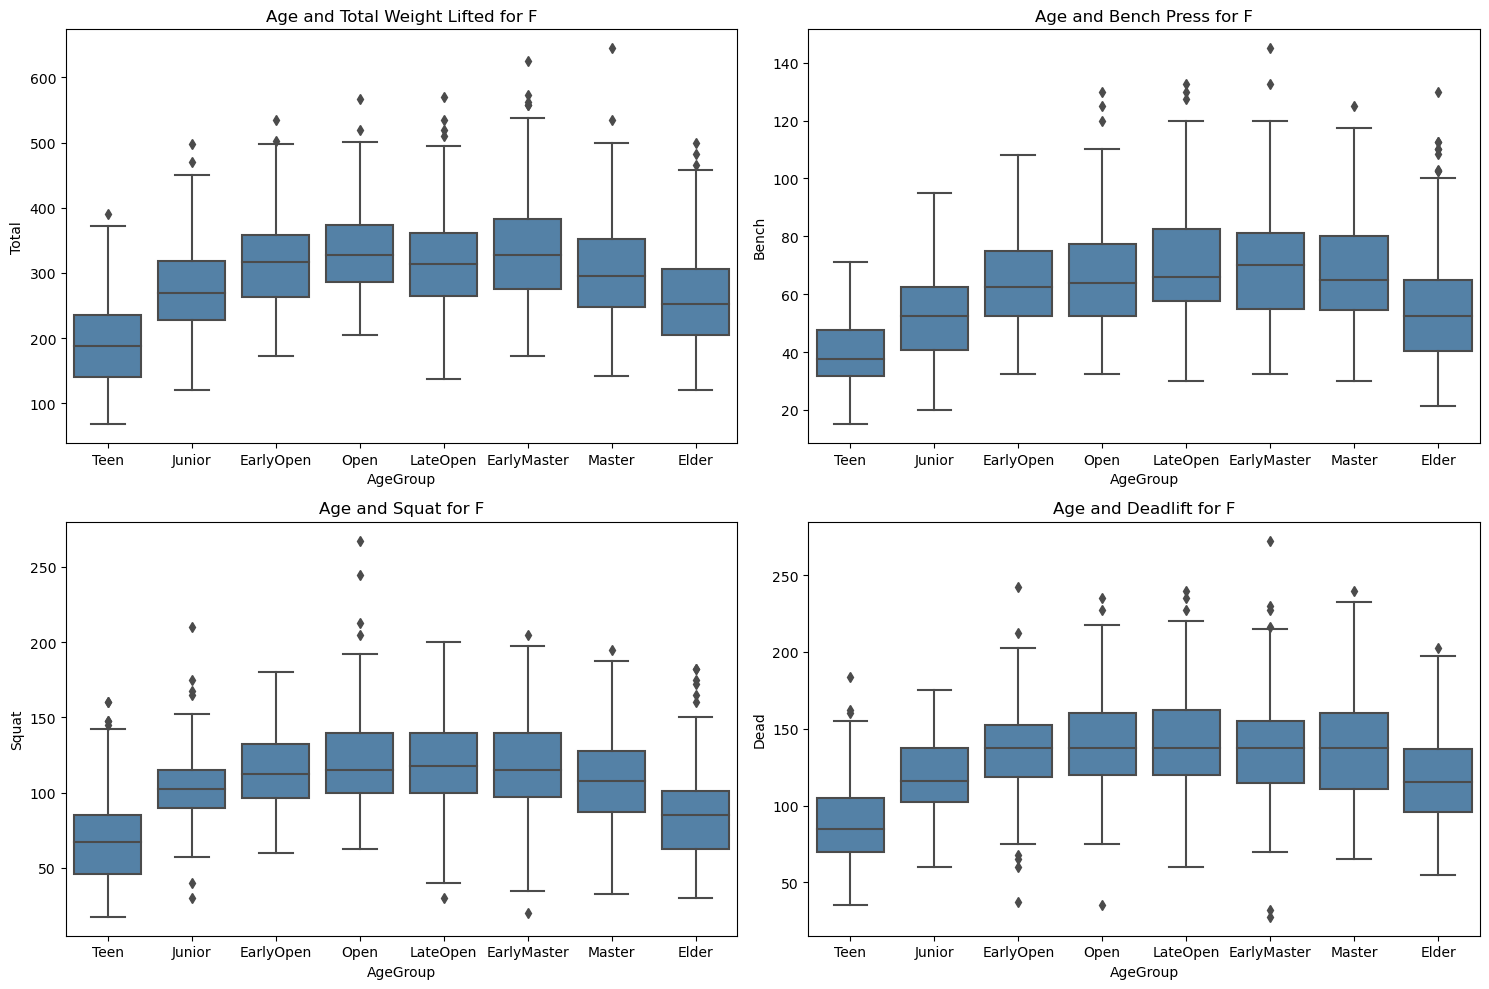

In [15]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Box')

Random Selected Sample Scatter Plot with Hue

In [16]:
def quadrant_hue(total,bench,squat,dead,sex,hue,group):
    fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))
    if group == 'Lighter':
        total = total[total['Weight'].isin(['Light','Middle'])]
        dead = dead[dead['Weight'].isin(['Light','Middle'])]
        squat = squat[squat['Weight'].isin(['Light','Middle'])]
        bench = bench[bench['Weight'].isin(['Light','Middle'])]
    elif group == 'Heavier':
        total = total[total['Weight'].isin(['Heavy','SuperHeavy'])]
        dead = dead[dead['Weight'].isin(['Heavy','SuperHeavy'])]
        squat = squat[squat['Weight'].isin(['Heavy','SuperHeavy'])]
        bench = bench[bench['Weight'].isin(['Heavy','SuperHeavy'])]
    
    axs[0,0].set_title('Age and Total Weight Lifted for '+sex)
    axs[0,1].set_title('Age and Bench Press for '+sex)
    axs[1,0].set_title('Age and Squat for '+sex)
    axs[1,1].set_title('Age and Deadlift for '+sex)

    common_xlim = (min(df['Age'])-10, max(df['Age'])+20)
    
    axs[0, 0].set_xlim(common_xlim)
    axs[0, 1].set_xlim(common_xlim)
    axs[1, 0].set_xlim(common_xlim)
    axs[1, 1].set_xlim(common_xlim)

    hue_order = total[hue].unique()

    palette = sns.color_palette('Accent', n_colors=len(hue_order))

    sns.scatterplot(data=total[total['Sex'] == sex].copy(), x='Age', y='Total', ax=axs[0, 0],
                    hue=hue, palette=palette, hue_order=hue_order)
    sns.scatterplot(data=bench[bench['Sex'] == sex].copy(), x='Age', y='Bench', ax=axs[0, 1],
                    hue=hue, palette=palette, hue_order=hue_order)
    sns.scatterplot(data=squat[squat['Sex'] == sex].copy(), x='Age', y='Squat', ax=axs[1, 0],
                    hue=hue, palette=palette, hue_order=hue_order)
    sns.scatterplot(data=dead[dead['Sex'] == sex].copy(), x='Age', y='Dead', ax=axs[1, 1],
                    hue=hue, palette=palette, hue_order=hue_order)
    plt.tight_layout()

Sex = M

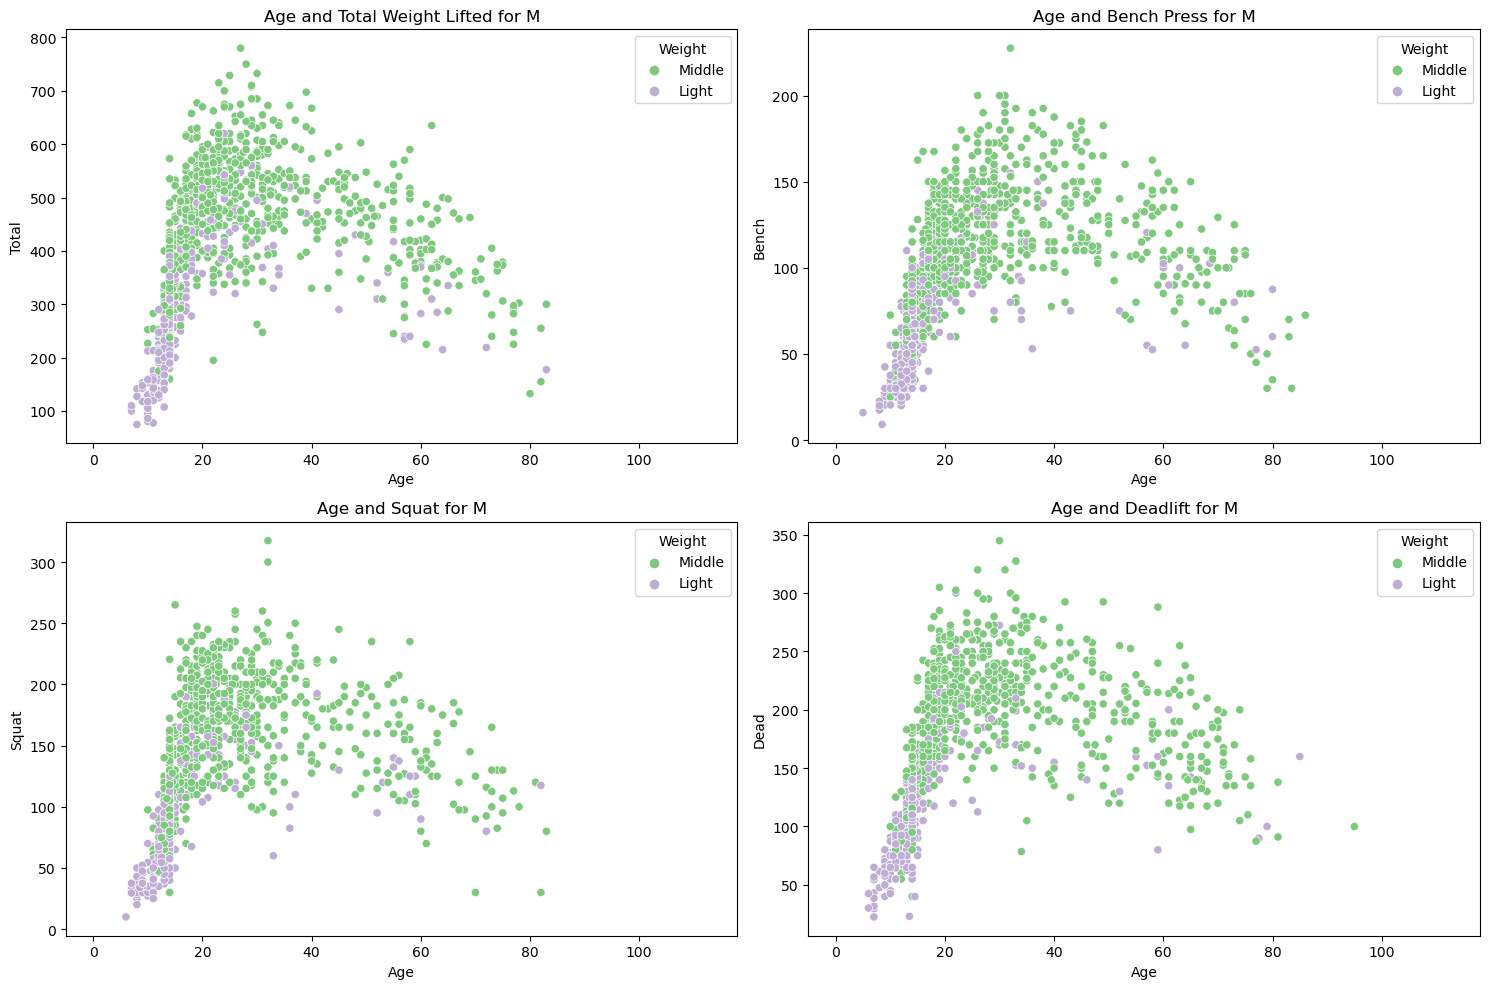

In [17]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Weight','Lighter')

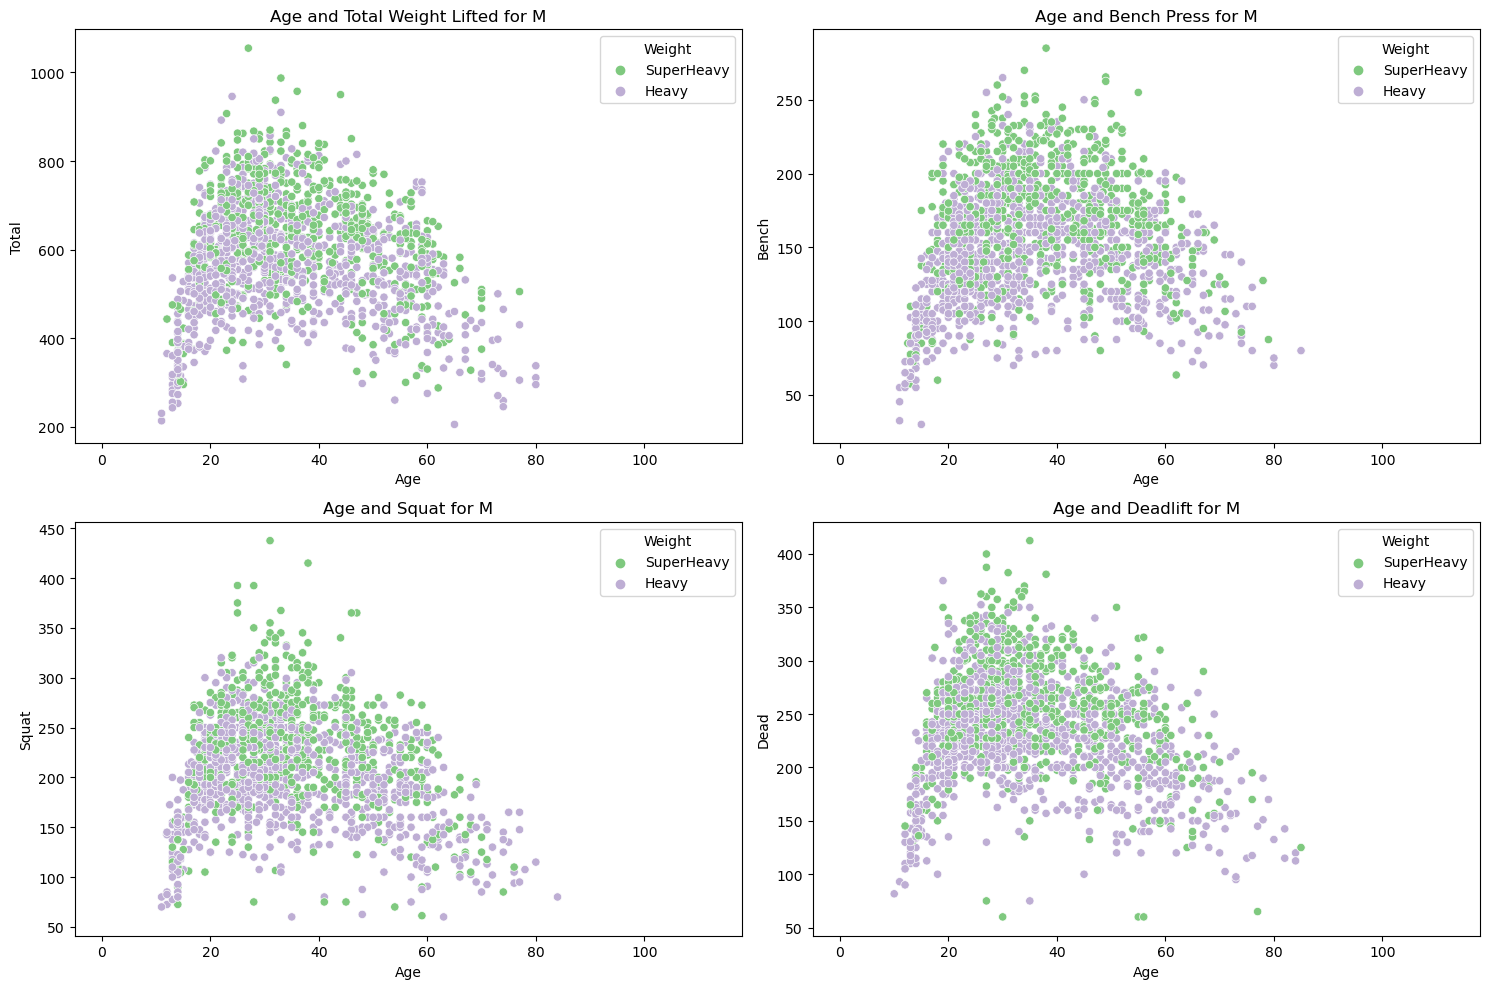

In [18]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Weight','Heavier')

Sex = F

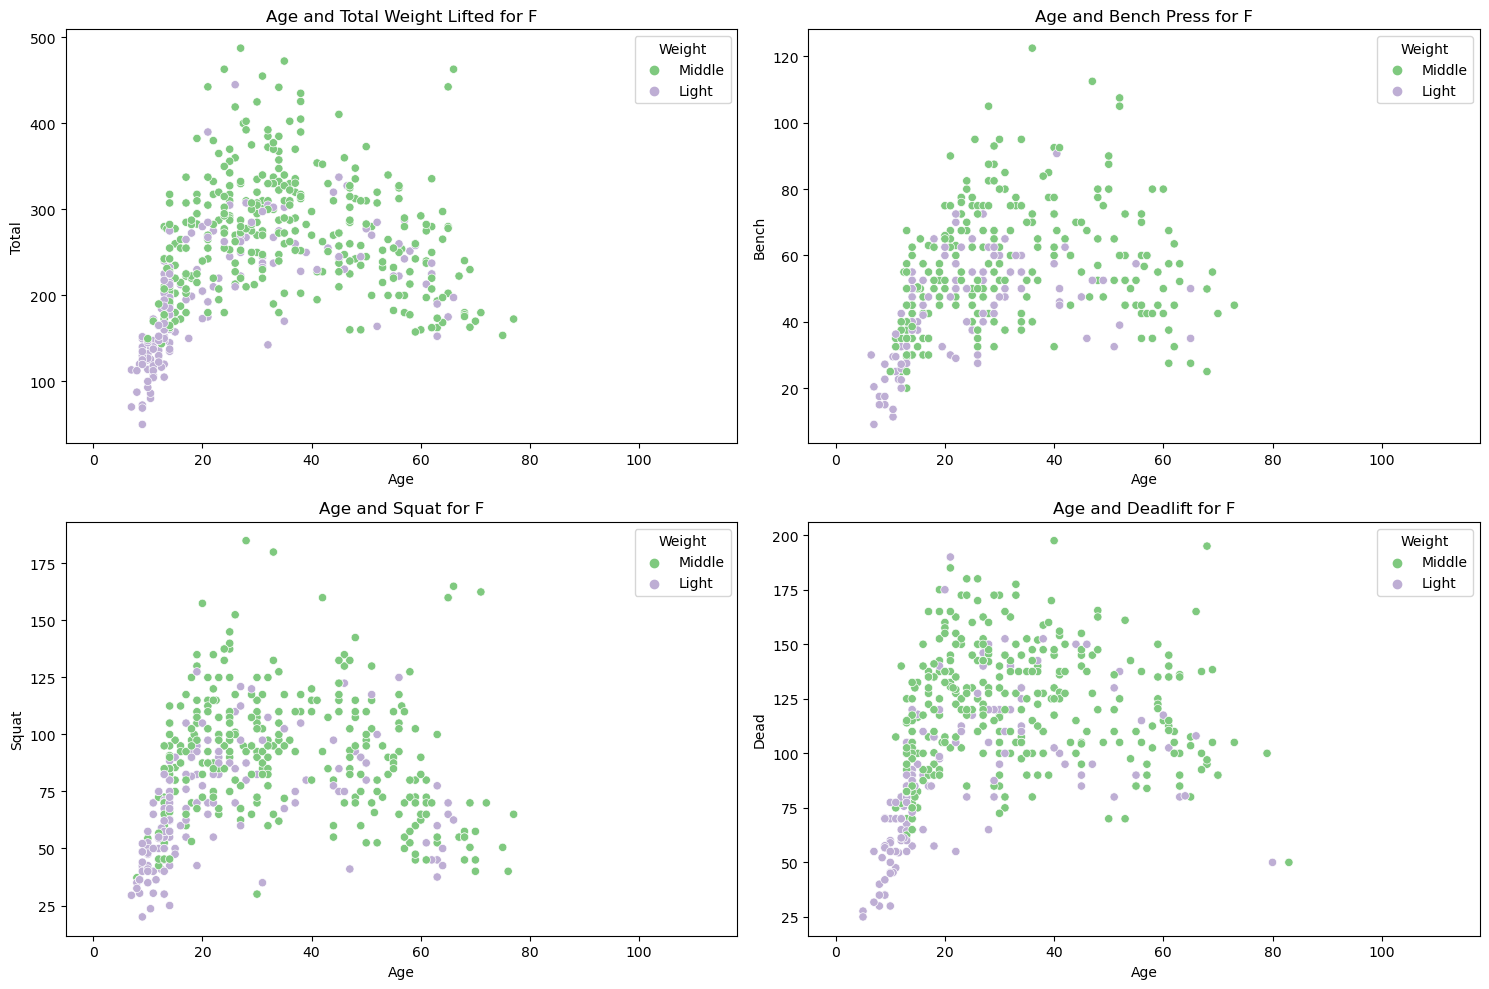

In [19]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Weight','Lighter')

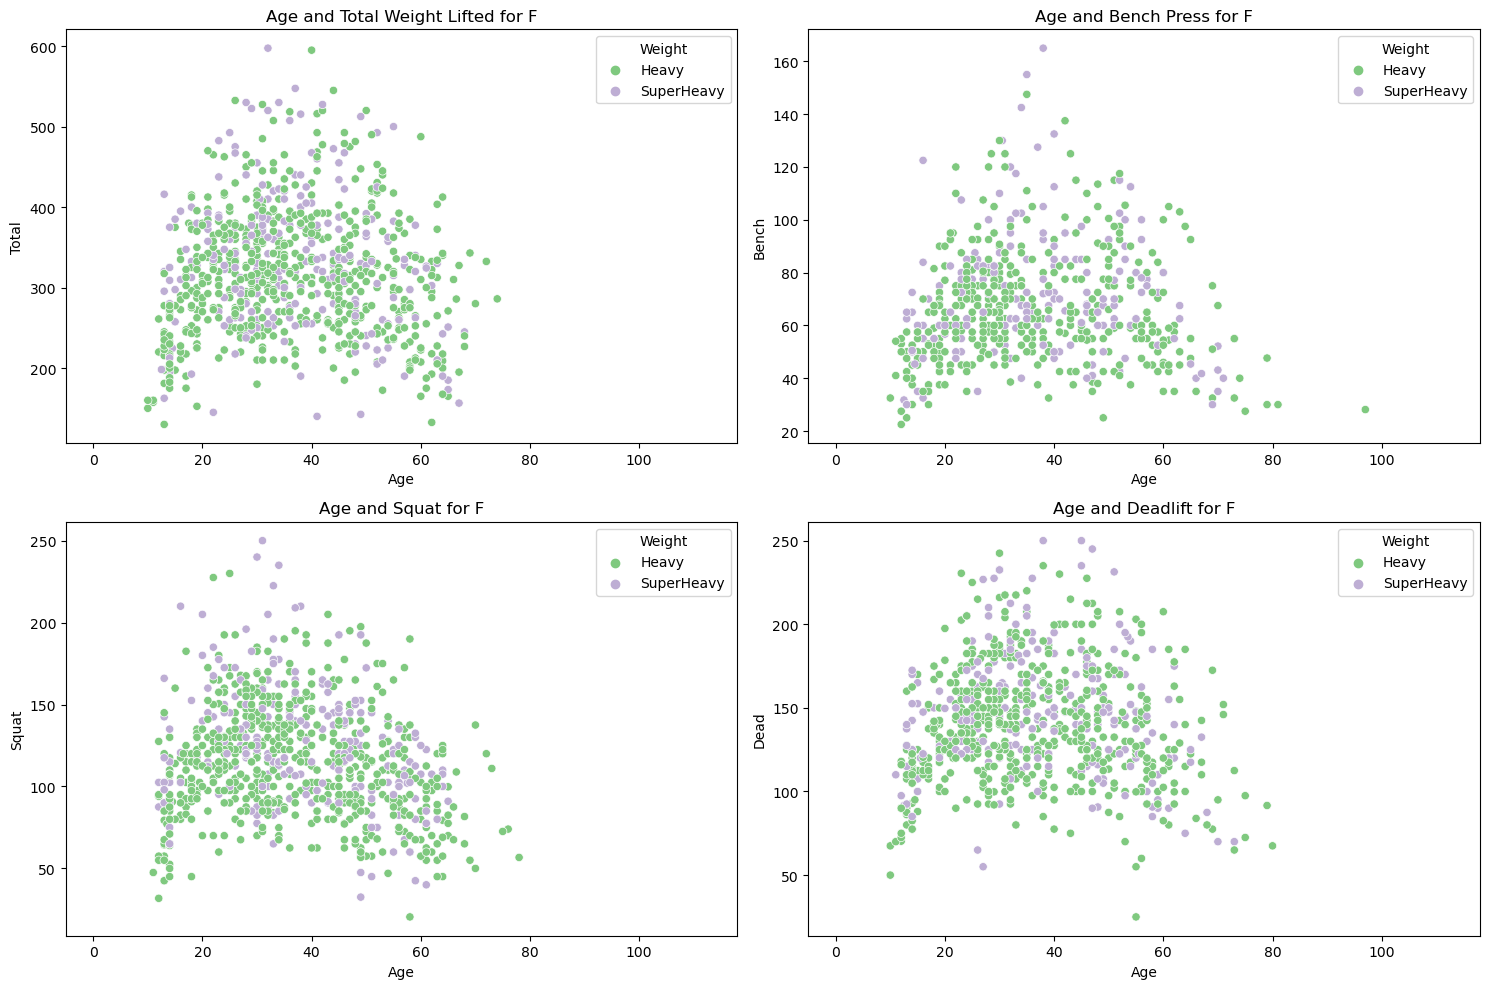

In [20]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Weight','Heavier')

# 1) Gaussian Distribution

Explore normality between Age Groups and Peak Strength levels across Total, Bench, Dead, and Squat

In [21]:
def max_strength(total, sex):
    summary = pd.DataFrame()
    col = total.columns[3]
    cutoff = total[total['Sex'] == sex].groupby('AgeGroup')[col].quantile(.9).reset_index().copy()
    return cutoff

def shapiro_wilk(total, sex, alpha):
    a = max_strength(total, sex)
    col = total.columns[3]
    stat, p = stats.shapiro(a[col])
    if p > alpha:
        return 'The data appears to be normally distributed (fail to reject H0)'
    else:
        return 'The data does not appear to be normally distributed (reject H0)'
        
def bar_quadrant(total, bench, squat, dead, sex):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    axs[0, 0].set_title('Top Total per Age Group for ' + sex)
    axs[0, 1].set_title('Top Bench Press per Age Group for ' + sex)
    axs[1, 0].set_title('Top Squat per Age Group for ' + sex)
    axs[1, 1].set_title('Top Deadlift per Age Group for ' + sex)

    sns.barplot(max_strength(total, sex), x='AgeGroup', y='Total', color='steelblue', ax=axs[0, 0])
    sns.barplot(max_strength(bench, sex), x='AgeGroup', y='Bench', color='steelblue', ax=axs[0, 1])
    sns.barplot(max_strength(squat, sex), x='AgeGroup', y='Squat', color='steelblue', ax=axs[1, 0])
    sns.barplot(max_strength(dead, sex), x='AgeGroup', y='Dead', color='steelblue', ax=axs[1, 1])
    
    total_conclusion = shapiro_wilk(total, sex, alpha=0.05)
    bench_conclusion = shapiro_wilk(bench, sex, alpha=0.05)
    squat_conclusion = shapiro_wilk(squat, sex, alpha=0.05)
    dead_conclusion = shapiro_wilk(dead, sex, alpha=0.05)
    for ax in axs.flat:
        for bar in ax.patches:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                    round(bar.get_height(), 2), ha='center', va='bottom')
        
    axs[0, 0].text(0.5, -0.2, total_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[0, 0].transAxes, fontsize=10, color='red')
    axs[0, 1].text(0.5, -0.2, bench_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[0, 1].transAxes, fontsize=10, color='red')
    axs[1, 0].text(0.5, -0.2, squat_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[1, 0].transAxes, fontsize=10, color='red')
    axs[1, 1].text(0.5, -0.2, dead_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[1, 1].transAxes, fontsize=10, color='red')

    plt.tight_layout()


Null Hypothesis: The distribution of Top Strength per Age Group is normally distributed.

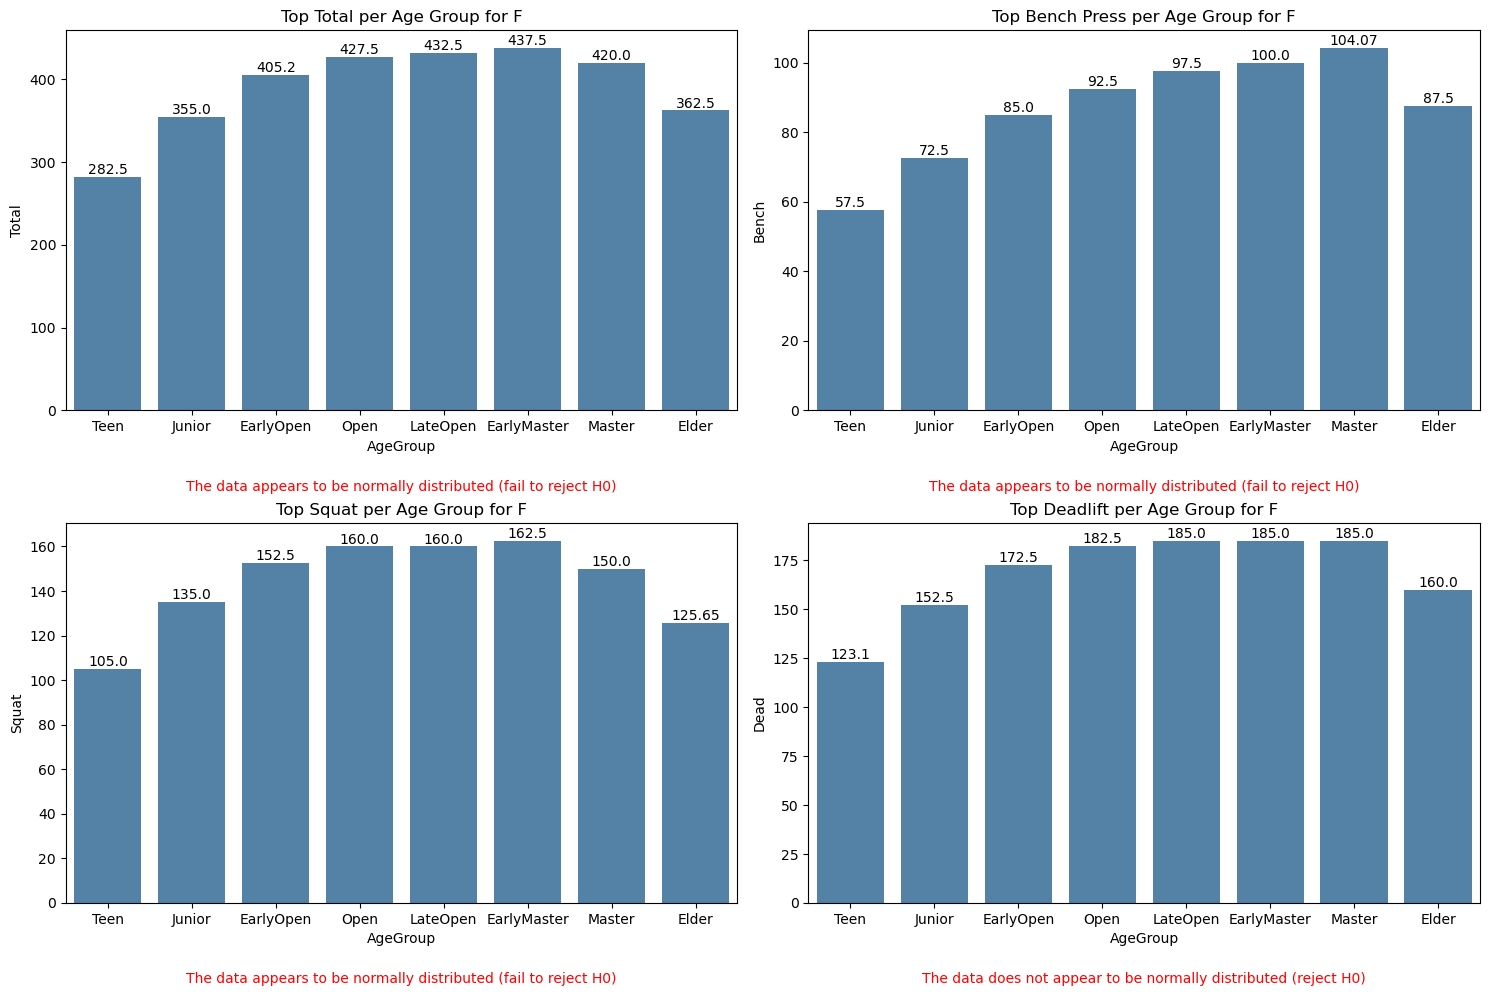

In [22]:
bar_quadrant(total,bench,squat,dead,'F')

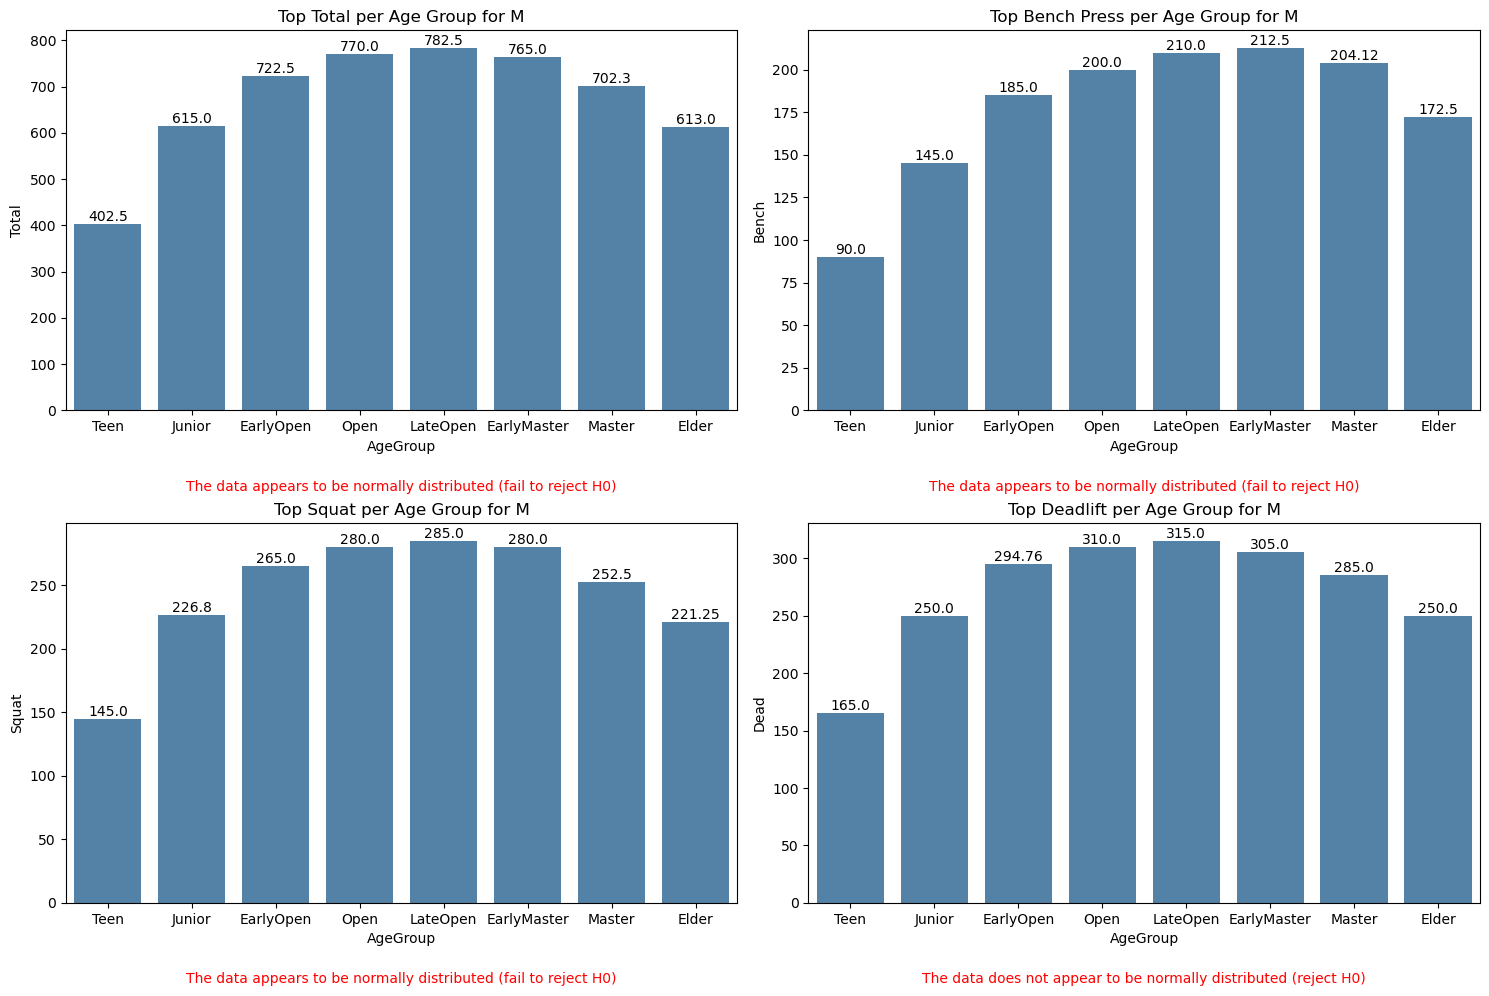

In [23]:
bar_quadrant(total,bench,squat,dead,'M')

# 2) Descriptive Statistical Testing

Top 10% of Total, Bench, Dead, and Squat for each Weight Group
- Statistical testing for difference in means in the top lifters per each weight class

In [112]:
def max_strength_df(total, sex):
    summary = pd.DataFrame()
    col = total.columns[3]
    cutoff = total[total['Sex'] == sex].groupby('Weight')[col].quantile(.9).reset_index().copy()
    for x in range(len(cutoff)):
        weight = cutoff.iloc[x,0]
        strength = cutoff.iloc[x,1]
        df = total[total['Sex'] == sex][(total[total['Sex'] == sex]['Weight']==weight)&(total[total['Sex'] == sex][col]>=strength)].copy()
        summary = pd.concat([summary, df], axis = 0, ignore_index = True)
    return summary

def mean_age_difference_z_test(total, sex, alpha):
    results = {}
    df = max_strength_df(total, sex)
    weight_groups = df['Weight'].unique()
    
    for i in range(len(weight_groups)):
        for j in range(i + 1, len(weight_groups)):
            group1 = weight_groups[i]
            group2 = weight_groups[j]
            sample1 = df[(df['Weight'] == group1) & (df['Sex'] == sex)]['Age']
            sample2 = df[(df['Weight'] == group2) & (df['Sex'] == sex)]['Age']
            z_stat, p_value = ztest(sample1, sample2)

            p_value_formatted = '{:.5f}'.format(p_value) 
            
            if p_value < alpha:
                decision = 'Reject H0: There is a significant difference'
            else:
                decision = 'Fail to reject H0: There is no significant difference'
            
            results[f'{group1} vs {group2}'] = {'Z statistic': z_stat,
                                                 'p-value': p_value_formatted,
                                                 'Decision': decision}
    print(df.groupby('Weight')['Age'].describe())
    return results

def mean_weight_age_z_test(total, sex, alpha):
    results = {}
    df = max_strength_df(total, sex)
    df = df[df['AgeGroup']!='Teen'] # low samples
    age_groups = df['AgeGroup'].unique()
    col = df.columns[3]
    top_age = df.groupby('AgeGroup')[col].mean().idxmax()
    age_groups = [x for x in age_groups if (x != top_age)]
    sample1 = df[(df['AgeGroup'] == top_age) & (df['Sex'] == sex)][col]
    for i in range(len(age_groups)):
        group2 = age_groups[i]
        sample2 = df[(df['AgeGroup'] == group2) & (df['Sex'] == sex)][col]
        z_stat, p_value = ztest(sample1, sample2)

        p_value_formatted = '{:.5f}'.format(p_value) 

        if p_value < alpha:
            decision = 'Reject H0: There is a significant difference'
        else:
            decision = 'Fail to reject H0: There is no significant difference'

        results[f'{top_age} vs {group2}'] = {'Z statistic': z_stat,
                                             'p-value': p_value_formatted,
                                             'Decision': decision}
    print(df.groupby('AgeGroup')[col].describe())
    return results

Null hypothesis: The mean weight lifted, in peak lifters, of the strongest Age Group is not different than the other Age Groups

Total Weight Lifted

In [113]:
mean_weight_age_z_test(total, 'F', .05)

             count        mean        std    min     25%    50%      75%  \
AgeGroup                                                                   
Teen           0.0         NaN        NaN    NaN     NaN    NaN      NaN   
Junior        62.0  417.854839  53.539275  315.0  375.00  422.5  458.875   
EarlyOpen    497.0  438.354447  61.469723  315.0  390.50  437.5  470.000   
Open         766.0  450.176110  61.752916  315.0  419.34  450.0  487.125   
LateOpen     610.0  461.822639  65.704346  315.0  425.00  460.0  503.750   
EarlyMaster  746.0  466.857453  63.212069  315.0  430.91  462.5  505.000   
Master       243.0  451.661852  58.078148  315.5  424.00  452.5  488.000   
Elder         57.0  459.666667  24.712875  370.0  442.50  462.5  475.000   

               max  
AgeGroup            
Teen           NaN  
Junior       572.5  
EarlyOpen    692.5  
Open         677.5  
LateOpen     702.5  
EarlyMaster  735.0  
Master       645.0  
Elder        505.0  


{'EarlyMaster vs LateOpen': {'Z statistic': 1.433419054864296,
  'p-value': '0.15174',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 5.928897935625324,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Open': {'Z statistic': 5.190606946667919,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 7.87359737359077,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Master': {'Z statistic': 3.318578390220022,
  'p-value': '0.00090',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Elder': {'Z statistic': 0.8534596903089416,
  'p-value': '0.39340',
  'Decision': 'Fail to reject H0: There is no significant difference'}}

In [114]:
mean_weight_age_z_test(total, 'M', .05)

              count        mean         std    min      25%     50%      75%  \
AgeGroup                                                                       
Teen            0.0         NaN         NaN    NaN      NaN     NaN      NaN   
Junior        178.0  663.971348   90.975640  495.0  627.500  652.50  717.500   
EarlyOpen    1476.0  725.144336  100.061058  495.0  650.000  730.50  792.500   
Open         1924.0  765.027438  106.061820  495.0  702.500  757.50  835.625   
LateOpen     1348.0  778.312804   97.298310  495.0  722.500  772.50  847.500   
EarlyMaster  1082.0  776.821266   96.829988  495.0  720.000  777.50  847.500   
Master         86.0  743.279070   94.486416  500.0  672.000  725.00  821.875   
Elder          22.0  713.922727   40.630178  635.0  689.675  728.25  742.500   

                max  
AgeGroup             
Teen            NaN  
Junior        962.5  
EarlyOpen    1045.0  
Open         1101.0  
LateOpen     1127.5  
EarlyMaster  1077.5  
Master        915.0  
E

{'LateOpen vs Open': {'Z statistic': 3.647622048330904,
  'p-value': '0.00026',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs EarlyOpen': {'Z statistic': 14.291048789576637,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs EarlyMaster': {'Z statistic': 0.3763699059094064,
  'p-value': '0.70664',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'LateOpen vs Master': {'Z statistic': 3.2429197763846678,
  'p-value': '0.00118',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Junior': {'Z statistic': 14.84467441899429,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Elder': {'Z statistic': 3.09869885958662,
  'p-value': '0.00194',
  'Decision': 'Reject H0: There is a significant difference'}}

Squat

In [115]:
mean_weight_age_z_test(squat, 'F', .05)

             count        mean        std    min    25%     50%    75%    max
AgeGroup                                                                     
Teen           0.0         NaN        NaN    NaN    NaN     NaN    NaN    NaN
Junior        84.0  153.839286  21.416152  112.5  137.5  155.00  170.0  220.0
EarlyOpen    626.0  162.747173  25.819656  112.5  143.5  160.00  177.5  265.0
Open         857.0  167.375508  26.149664  112.5  155.0  165.00  183.0  267.5
LateOpen     638.0  170.932962  27.297926  112.5  155.0  167.75  187.5  267.5
EarlyMaster  765.0  173.127255  24.124800  112.5  157.5  170.00  185.5  272.5
Master       223.0  168.464081  22.046771  115.0  155.0  165.00  182.5  240.0
Elder         52.0  169.971154  14.517877  125.0  162.5  167.50  173.5  217.5


{'EarlyMaster vs LateOpen': {'Z statistic': 1.5976809445575244,
  'p-value': '0.11011',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 7.029052383129947,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Open': {'Z statistic': 4.586026819870886,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 7.734389879788756,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Master': {'Z statistic': 2.5884266751152274,
  'p-value': '0.00964',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Elder': {'Z statistic': 0.931651955665188,
  'p-value': '0.35152',
  'Decision': 'Fail to reject H0: There is no significant difference'}}

In [116]:
mean_weight_age_z_test(squat, 'M', .05)

              count        mean        std    min      25%    50%      75%  \
AgeGroup                                                                     
Teen            0.0         NaN        NaN    NaN      NaN    NaN      NaN   
Junior        271.0  239.064317  40.531379  175.0  222.500  235.0  262.500   
EarlyOpen    1640.0  265.269104  40.547499  175.0  232.875  265.0  290.000   
Open         1902.0  281.234700  44.391825  175.0  255.000  275.0  312.500   
LateOpen     1279.0  288.951884  42.326272  175.0  261.000  285.0  318.255   
EarlyMaster  1110.0  287.580018  42.054711  175.0  260.000  282.5  320.000   
Master        135.0  276.235481  39.633241  177.5  245.250  272.5  306.835   
Elder          20.0  260.948000  17.420295  230.0  249.480  262.5  275.000   

               max  
AgeGroup            
Teen           NaN  
Junior       410.0  
EarlyOpen    410.0  
Open         440.0  
LateOpen     465.0  
EarlyMaster  425.0  
Master       365.0  
Elder        285.0  


{'LateOpen vs Open': {'Z statistic': 4.89776483572346,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs EarlyOpen': {'Z statistic': 15.358254819610751,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs EarlyMaster': {'Z statistic': 0.7924734098931379,
  'p-value': '0.42808',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'LateOpen vs Master': {'Z statistic': 3.339531662112016,
  'p-value': '0.00084',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Junior': {'Z statistic': 17.75429659270991,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Elder': {'Z statistic': 2.954012637936708,
  'p-value': '0.00314',
  'Decision': 'Reject H0: There is a significant difference'}}

Bench

In [117]:
mean_weight_age_z_test(bench, 'F', .05)

              count        mean        std   min       25%     50%     75%  \
AgeGroup                                                                     
Teen            0.0         NaN        NaN   NaN       NaN     NaN     NaN   
Junior         86.0   89.475930  17.527361  65.0   71.4825   88.75  102.06   
EarlyOpen     528.0   94.756610  17.890038  65.0   82.5000   92.50  105.00   
Open          755.0  100.694358  18.014121  65.0   85.5900  102.50  112.50   
LateOpen      825.0  105.589091  20.251773  65.0   90.0000  105.00  120.00   
EarlyMaster  1337.0  108.595512  21.019342  65.0   97.5000  107.50  120.00   
Master        726.0  107.082576  16.632552  65.0  100.0000  107.50  117.50   
Elder         187.0  102.666898  13.305047  65.0   95.0000  102.50  110.00   

               max  
AgeGroup            
Teen           NaN  
Junior       142.5  
EarlyOpen    165.0  
Open         157.5  
LateOpen     166.0  
EarlyMaster  180.0  
Master       170.0  
Elder        135.5  


{'EarlyMaster vs Master': {'Z statistic': 1.6753414798618795,
  'p-value': '0.09387',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs Open': {'Z statistic': 8.683485412253038,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs LateOpen': {'Z statistic': 3.2758036371807693,
  'p-value': '0.00105',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 13.339834987323394,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Elder': {'Z statistic': 3.752708721082111,
  'p-value': '0.00017',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 8.25212053941849,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [118]:
mean_weight_age_z_test(bench, 'M', .05)

              count        mean        std    min    25%    50%       75%  \
AgeGroup                                                                    
Teen            0.0         NaN        NaN    NaN    NaN    NaN       NaN   
Junior        168.0  163.183571  35.244482  120.0  127.5  162.5  191.0075   
EarlyOpen    1500.0  188.617800  31.408699  120.0  165.0  192.5  207.5000   
Open         2941.0  201.338711  32.696457  120.0  180.0  200.0  225.0000   
LateOpen     2897.0  206.448357  31.514212  120.0  190.0  202.5  227.5000   
EarlyMaster  4014.0  209.138373  29.644345  120.0  190.0  210.0  230.0000   
Master       1196.0  204.497458  30.373382  120.0  182.5  202.5  227.5000   
Elder         157.0  203.848280  32.496033  120.0  190.0  200.0  230.0000   

                max  
AgeGroup             
Teen            NaN  
Junior       250.00  
EarlyOpen    288.03  
Open         325.00  
LateOpen     355.00  
EarlyMaster  335.00  
Master       290.00  
Elder        255.00  


{'EarlyMaster vs Master': {'Z statistic': 4.7253110348008684,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 22.50235480596319,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Open': {'Z statistic': 10.375271802723356,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs LateOpen': {'Z statistic': 3.6247048427177684,
  'p-value': '0.00029',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Elder': {'Z statistic': 2.1852822237427034,
  'p-value': '0.02887',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 19.52460513130474,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Dead

In [119]:
mean_weight_age_z_test(dead, 'F', .05)

              count        mean        std     min    25%     50%      75%  \
AgeGroup                                                                     
Teen            0.0         NaN        NaN     NaN    NaN     NaN      NaN   
Junior         82.0  177.079268  19.287697  140.00  165.0  171.25  191.875   
EarlyOpen     647.0  184.890046  23.113749  140.00  167.5  185.00  197.500   
Open         1024.0  189.291074  23.821394  140.00  172.5  190.00  204.340   
LateOpen      930.0  193.283624  23.637693  140.00  182.5  192.50  207.500   
EarlyMaster  1223.0  196.803083  24.252275  140.00  182.5  195.00  210.000   
Master        453.0  194.360530  23.630319  140.00  182.5  195.00  207.500   
Elder         103.0  193.167767  13.954419  140.61  185.0  195.00  202.500   

               max  
AgeGroup            
Teen           NaN  
Junior       230.0  
EarlyOpen    282.5  
Open         275.0  
LateOpen     280.0  
EarlyMaster  290.0  
Master       280.0  
Elder        217.5  


{'EarlyMaster vs Open': {'Z statistic': 7.371880412966258,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Master': {'Z statistic': 1.8437668515294634,
  'p-value': '0.06522',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs LateOpen': {'Z statistic': 3.3721007741409568,
  'p-value': '0.00075',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 10.268600062391872,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 7.212266562000143,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Elder': {'Z statistic': 1.5001642971488396,
  'p-value': '0.13357',
  'Decision': 'Fail to reject H0: There is no significant difference'}}

In [120]:
mean_weight_age_z_test(dead, 'M', .05)

              count        mean        std    min      25%     50%      75%  \
AgeGroup                                                                      
Teen            0.0         NaN        NaN    NaN      NaN     NaN      NaN   
Junior        372.0  275.711559  39.395899  207.5  260.000  275.25  301.855   
EarlyOpen    2215.0  299.237914  37.959796  207.5  272.500  300.00  323.500   
Open         2943.0  312.161386  37.144032  207.5  295.000  317.50  335.000   
LateOpen     2221.0  315.182864  33.829571  207.5  297.500  320.00  335.000   
EarlyMaster  1822.0  314.068666  32.493311  207.5  297.000  320.00  332.500   
Master        277.0  306.769206  29.376283  212.5  295.000  305.00  325.000   
Elder          43.0  305.015814  23.540703  260.0  286.515  310.00  322.525   

                max  
AgeGroup             
Teen            NaN  
Junior       390.00  
EarlyOpen    432.50  
Open         487.50  
LateOpen     447.50  
EarlyMaster  421.00  
Master       390.00  
Elder      

{'LateOpen vs EarlyOpen': {'Z statistic': 14.769796753514704,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs EarlyMaster': {'Z statistic': 1.0606577282502312,
  'p-value': '0.28885',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'LateOpen vs Open': {'Z statistic': 3.0063769179466844,
  'p-value': '0.00264',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Master': {'Z statistic': 3.9572518141810478,
  'p-value': '0.00008',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Junior': {'Z statistic': 20.31555735815653,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Elder': {'Z statistic': 1.9613645924058893,
  'p-value': '0.04984',
  'Decision': 'Reject H0: There is a significant difference'}}

Null Hypothesis: The mean Age of the top lifters in all Weight Groups of the same Sex are not different.

Total Weight Lifted

In [33]:
mean_age_difference_z_test(total,'M',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       2455.0  29.038086  6.365840  17.0  24.0  28.0  32.0  60.0
Light        296.0  26.158784  6.129544  15.0  22.0  25.0  29.0  54.0
Middle      1729.0  27.887507  6.673342  15.0  23.0  27.0  31.0  62.5
SuperHeavy  1636.0  30.819071  5.825912  18.0  26.0  30.0  35.0  48.0


{'Heavy vs Light': {'Z statistic': 7.380100838123137,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 5.64269863624414,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -9.06546950383972,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -4.166013566086271,
  'p-value': '0.00003',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -12.562081008607374,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -13.54368917083245,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [34]:
mean_age_difference_z_test(total,'F',.05)

             count       mean        std   min   25%   50%   75%   max
Weight                                                                
Heavy       1492.0  32.827413   9.104185  15.0  26.0  31.0  38.0  69.0
Light        210.0  29.814286   7.977617  15.0  24.0  28.0  33.0  51.0
Middle       687.0  31.499272  10.040534  17.0  24.0  29.0  36.0  71.0
SuperHeavy   592.0  33.622466   7.762809  16.0  28.0  33.0  39.0  56.0


{'Heavy vs Light': {'Z statistic': 4.555950107915261,
  'p-value': '0.00001',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 3.0614057882049797,
  'p-value': '0.00220',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -1.8718225436856841,
  'p-value': '0.06123',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light vs Middle': {'Z statistic': -2.2262913581813524,
  'p-value': '0.02599',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -6.063480941894686,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -4.179913061870419,
  'p-value': '0.00003',
  'Decision': 'Reject H0: There is a significant difference'}}

Squat

In [35]:
mean_age_difference_z_test(squat,'M',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       2615.0  29.016444  6.790301  15.5  24.0  28.0  32.0  59.0
Light        327.0  25.056575  6.344701  15.0  21.0  24.0  28.0  54.0
Middle      1762.0  27.583428  6.939126  15.0  23.0  26.0  31.0  62.5
SuperHeavy  1653.0  30.741379  6.235234  17.0  26.0  30.0  35.0  53.0


{'Heavy vs Light': {'Z statistic': 10.012865010741901,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 6.786928111878131,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -8.341556415802506,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -6.1265739137169755,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -15.020227761457075,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -13.957037719898679,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [36]:
mean_age_difference_z_test(squat,'F',.05)

             count       mean        std   min   25%   50%   75%   max
Weight                                                                
Heavy       1661.0  31.994281   8.751358  15.0  25.0  30.0  38.0  61.0
Light        240.0  28.250000   6.732330  15.0  23.0  27.0  31.0  56.0
Middle       703.0  30.733286  10.133387  15.0  24.0  28.0  35.0  71.0
SuperHeavy   642.0  33.297508   7.915079  14.0  28.0  32.0  39.0  56.0


{'Heavy vs Light': {'Z statistic': 6.361282545760549,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 3.051596896943204,
  'p-value': '0.00228',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -3.2888774843944892,
  'p-value': '0.00101',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -3.538549239444928,
  'p-value': '0.00040',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -8.764233114290132,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -5.138048129941759,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Bench

In [37]:
mean_age_difference_z_test(bench,'M',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       5201.0  33.420400  8.081889  15.0  27.5  32.0  38.0  64.0
Light        629.0  28.616852  8.543087  15.0  23.0  27.0  33.0  62.0
Middle      3218.0  32.846333  8.621226  15.0  26.0  31.0  38.0  72.0
SuperHeavy  3825.0  35.299869  7.721139  17.0  29.0  35.0  40.0  62.0


{'Heavy vs Light': {'Z statistic': 13.991175042314461,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 3.0867434937298395,
  'p-value': '0.00202',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -11.12544996726813,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -11.26980048161413,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -19.805911638216617,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -12.593468962203222,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [38]:
mean_age_difference_z_test(bench,'F',.05)

             count       mean        std   min   25%   50%   75%   max
Weight                                                                
Heavy       2094.0  36.979704  10.409987  15.0  29.0  36.0  44.0  69.0
Light        413.0  31.205811   9.490287  13.0  23.5  29.0  37.0  63.0
Middle      1128.0  34.387855  10.858739  14.0  26.0  32.0  40.0  71.0
SuperHeavy   814.0  37.027641   8.872205  16.0  30.0  37.0  42.0  61.0


{'Heavy vs Light': {'Z statistic': 10.447728804416254,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 6.639677885067653,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -0.11601672279959846,
  'p-value': '0.90764',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light vs Middle': {'Z statistic': -5.2642534353244725,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -10.607430918125393,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -5.697804121241232,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Deadlift

In [39]:
mean_age_difference_z_test(dead,'M',.05)

             count       mean       std   min   25%    50%   75%   max
Weight                                                                
Heavy       3727.0  29.386370  6.985427  16.0  24.0  28.00  33.0  64.0
Light        543.0  25.686924  6.506281  15.0  21.0  24.00  29.0  54.0
Middle      2567.0  28.308337  7.162726  15.0  23.0  27.00  32.0  64.0
SuperHeavy  3056.0  31.422775  6.544829  18.0  27.0  30.25  36.0  57.0


{'Heavy vs Light': {'Z statistic': 11.627694521988918,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 5.954743485271551,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -12.288815018175887,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -7.868929989301933,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -18.83518154512742,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -17.02240182432121,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [40]:
mean_age_difference_z_test(dead,'F',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       2213.0  33.934704  9.152276  15.0  27.0  32.0  39.0  67.0
Light        376.0  30.577128  8.130316  17.0  24.0  29.0  36.0  69.0
Middle      1054.0  32.084440  9.919547  15.0  25.0  30.0  37.0  71.0
SuperHeavy   819.0  35.242369  8.543334  16.0  29.0  34.0  41.0  62.0


{'Heavy vs Light': {'Z statistic': 6.679684766383047,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 5.2557998717032195,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -3.5555824658374675,
  'p-value': '0.00038',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -2.6462438163398447,
  'p-value': '0.00814',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -8.898895723905682,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -7.2563244602949535,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Null Hypothesis: The mean Age of the top lifters in each Weight Group are the same across Sex.

In [41]:
def mean_age_difference_z_test_2(total, alpha):
    results = {}
    df1 = max_strength_df(total, 'M')
    df2 = max_strength_df(total,'F')
    
    weight_groups = df['Weight'].unique()
    
    for i in range(len(weight_groups)):
        weight = weight_groups[i]
        sample1 = df1[df1['Weight']==weight]['Age'].copy()
        sample2 = df2[df2['Weight']==weight]['Age'].copy()
        z_stat, p_value = ztest(sample1, sample2)

        p_value_formatted = '{:.5f}'.format(p_value) 

        if p_value < alpha:
            decision = 'Reject H0: There is a significant difference'
        else:
            decision = 'Fail to reject H0: There is no significant difference'

        results[f'F v M in {weight}'] = {'Z statistic': z_stat,
                                             'p-value': p_value_formatted,
                                             'Decision': decision}
    dfs = pd.concat([df2.groupby('Weight')['Age'].mean(),
           df1.groupby('Weight')['Age'].mean()], axis = 1)
    dfs['Delta'] = dfs.iloc[:,0]-dfs.iloc[:,1]
    dfs.columns = ['F mean age','M mean age', 'Delta']
    print(dfs)
    return results

In [42]:
mean_age_difference_z_test_2(total,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        32.827413   29.038086  3.789327
Light        29.814286   26.158784  3.655502
Middle       31.499272   27.887507  3.611765
SuperHeavy   33.622466   30.819071  2.803395


{'F v M in Heavy': {'Z statistic': -15.352586605743195,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': -9.136141605642269,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Middle': {'Z statistic': -10.293756240496549,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Light': {'Z statistic': -5.824826341400668,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [43]:
mean_age_difference_z_test_2(squat,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        31.994281   29.016444  2.977837
Light        28.250000   25.056575  3.193425
Middle       30.733286   27.583428  3.149858
SuperHeavy   33.297508   30.741379  2.556128


{'F v M in Heavy': {'Z statistic': -12.467864249423451,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': -8.1466596703374,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Middle': {'Z statistic': -8.8473167234762,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Light': {'Z statistic': -5.7698491591942505,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [44]:
mean_age_difference_z_test_2(bench,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        36.979704   33.420400  3.559304
Light        31.205811   28.616852  2.588959
Middle       34.387855   32.846333  1.541521
SuperHeavy   37.027641   35.299869  1.727772


{'F v M in Heavy': {'Z statistic': -15.604574860787832,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': -5.640963981053185,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Middle': {'Z statistic': -4.81426740054715,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Light': {'Z statistic': -4.57744630079635,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [45]:
mean_age_difference_z_test_2(dead,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        33.934704   29.386370  4.548334
Light        30.577128   25.686924  4.890203
Middle       32.084440   28.308337  3.776104
SuperHeavy   35.242369   31.422775  3.819594


{'F v M in Heavy': {'Z statistic': -21.555440590613458,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': -13.838921204866311,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Middle': {'Z statistic': -12.802151343378284,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Light': {'Z statistic': -10.102820849594506,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

# 3) Peak Age Linear Regression Testing

Exploring the relationship leading up to and after the Peak Age per Weight Group for top strength levels

In [46]:
def pre_peak_lin(total,sex):
    aa = max_strength_df(total,sex)
    a = aa.groupby('Weight')['Age'].describe()[['mean','std']]
    col = aa.columns[3]

    a['high'] = a['mean']-a['std']
    results = {}
    for x in range(len(a)):
        weight = a.index[x]
        high = a.iloc[x,2]
        high_df = aa[(aa['Weight']== a.index[x])&(aa['Age']<=high)].copy()
        high_r = stats.linregress(high_df['Age'],high_df[col])
        results[f'{col} and Age Pre-Peak Age for {weight} {sex}'] = {'Peak-Age':round(high,2),
                                                                     'Slope':round(stats.linregress(high_df['Age'],high_df[col])[0],2),
                                                                'p-value':'{:.5f}'.format(stats.linregress(high_df['Age'],high_df[col])[3]),
                                                                'R':round(stats.linregress(high_df['Age'],high_df[col])[2],2)}
    return results

Null Hypothesis: The slope of the linear relationship between Age and Strength is 0 for top lifters leading up to Peak Age

Sex: M

In [47]:
pre_peak_lin(total,'M')

{'Total and Age Pre-Peak Age for Heavy M': {'Peak-Age': 22.67,
  'Slope': 7.81,
  'p-value': '0.00014',
  'R': 0.22},
 'Total and Age Pre-Peak Age for Light M': {'Peak-Age': 20.03,
  'Slope': 1.54,
  'p-value': '0.52776',
  'R': 0.1},
 'Total and Age Pre-Peak Age for Middle M': {'Peak-Age': 21.21,
  'Slope': -0.34,
  'p-value': '0.84892',
  'R': -0.01},
 'Total and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 24.99,
  'Slope': -2.83,
  'p-value': '0.26474',
  'R': -0.07}}

In [48]:
pre_peak_lin(squat,'M')

{'Squat and Age Pre-Peak Age for Heavy M': {'Peak-Age': 22.23,
  'Slope': 2.57,
  'p-value': '0.00006',
  'R': 0.21},
 'Squat and Age Pre-Peak Age for Light M': {'Peak-Age': 18.71,
  'Slope': 1.54,
  'p-value': '0.22364',
  'R': 0.19},
 'Squat and Age Pre-Peak Age for Middle M': {'Peak-Age': 20.64,
  'Slope': 0.07,
  'p-value': '0.93669',
  'R': 0.01},
 'Squat and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 24.51,
  'Slope': -0.41,
  'p-value': '0.62263',
  'R': -0.03}}

In [49]:
pre_peak_lin(bench,'M')

{'Bench and Age Pre-Peak Age for Heavy M': {'Peak-Age': 25.34,
  'Slope': 0.03,
  'p-value': '0.90765',
  'R': 0.0},
 'Bench and Age Pre-Peak Age for Light M': {'Peak-Age': 20.07,
  'Slope': 0.45,
  'p-value': '0.46375',
  'R': 0.08},
 'Bench and Age Pre-Peak Age for Middle M': {'Peak-Age': 24.23,
  'Slope': 1.2,
  'p-value': '0.00017',
  'R': 0.16},
 'Bench and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 27.58,
  'Slope': 1.02,
  'p-value': '0.00061',
  'R': 0.14}}

In [50]:
pre_peak_lin(dead,'M')

{'Dead and Age Pre-Peak Age for Heavy M': {'Peak-Age': 22.4,
  'Slope': 1.87,
  'p-value': '0.00318',
  'R': 0.13},
 'Dead and Age Pre-Peak Age for Light M': {'Peak-Age': 19.18,
  'Slope': 0.12,
  'p-value': '0.91111',
  'R': 0.01},
 'Dead and Age Pre-Peak Age for Middle M': {'Peak-Age': 21.15,
  'Slope': 0.43,
  'p-value': '0.47279',
  'R': 0.04},
 'Dead and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 24.88,
  'Slope': 1.7,
  'p-value': '0.01816',
  'R': 0.12}}

Sex: F

In [51]:
pre_peak_lin(total,'F')

{'Total and Age Pre-Peak Age for Heavy F': {'Peak-Age': 23.72,
  'Slope': 5.3,
  'p-value': '0.00098',
  'R': 0.22},
 'Total and Age Pre-Peak Age for Light F': {'Peak-Age': 21.84,
  'Slope': 11.74,
  'p-value': '0.01233',
  'R': 0.56},
 'Total and Age Pre-Peak Age for Middle F': {'Peak-Age': 21.46,
  'Slope': 5.12,
  'p-value': '0.12363',
  'R': 0.18},
 'Total and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 25.86,
  'Slope': -4.9,
  'p-value': '0.02282',
  'R': -0.25}}

In [52]:
pre_peak_lin(squat,'F')

{'Squat and Age Pre-Peak Age for Heavy F': {'Peak-Age': 23.24,
  'Slope': 1.46,
  'p-value': '0.00813',
  'R': 0.16},
 'Squat and Age Pre-Peak Age for Light F': {'Peak-Age': 21.52,
  'Slope': 1.62,
  'p-value': '0.16511',
  'R': 0.3},
 'Squat and Age Pre-Peak Age for Middle F': {'Peak-Age': 20.6,
  'Slope': 2.47,
  'p-value': '0.01876',
  'R': 0.29},
 'Squat and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 25.38,
  'Slope': -1.21,
  'p-value': '0.11280',
  'R': -0.16}}

In [53]:
pre_peak_lin(bench,'F')

{'Bench and Age Pre-Peak Age for Heavy F': {'Peak-Age': 26.57,
  'Slope': 0.55,
  'p-value': '0.01758',
  'R': 0.13},
 'Bench and Age Pre-Peak Age for Light F': {'Peak-Age': 21.72,
  'Slope': 1.6,
  'p-value': '0.00635',
  'R': 0.38},
 'Bench and Age Pre-Peak Age for Middle F': {'Peak-Age': 23.53,
  'Slope': -0.32,
  'p-value': '0.34051',
  'R': -0.07},
 'Bench and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 28.16,
  'Slope': 0.03,
  'p-value': '0.94007',
  'R': 0.01}}

In [54]:
pre_peak_lin(dead,'F')

{'Dead and Age Pre-Peak Age for Heavy F': {'Peak-Age': 24.78,
  'Slope': 0.5,
  'p-value': '0.29575',
  'R': 0.06},
 'Dead and Age Pre-Peak Age for Light F': {'Peak-Age': 22.45,
  'Slope': 1.72,
  'p-value': '0.25634',
  'R': 0.16},
 'Dead and Age Pre-Peak Age for Middle F': {'Peak-Age': 22.16,
  'Slope': 1.56,
  'p-value': '0.00198',
  'R': 0.26},
 'Dead and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 26.7,
  'Slope': 0.17,
  'p-value': '0.79504',
  'R': 0.02}}

Null Hypothesis: The slope of the linear relationship between Age and Strength is 0 for top lifters after to Peak Age

In [55]:
def post_peak_lin(total,sex):
    aa = max_strength_df(total,sex)
    a = aa.groupby('Weight')['Age'].describe()[['mean','std']]
    col = aa.columns[3]
    a['low'] = a['mean']+a['std']
    results = {}
    for x in range(len(a)):
        weight = a.index[x]
        low = a.iloc[x,2]
        low_df = aa[(aa['Weight']== a.index[x])&(aa['Age']>=low)].copy()
        low_r = stats.linregress(low_df['Age'],low_df[col])
        results[f'{col} and Age Post-Peak Age for {weight} {sex}'] = {'Peak-Age':round(low,2),
                                                                      'Slope':round(stats.linregress(low_df['Age'],low_df[col])[0],2),
                                                                'p-value':'{:.5f}'.format(stats.linregress(low_df['Age'],low_df[col])[3]),
                                                                'R':round(stats.linregress(low_df['Age'],low_df[col])[2],2)}
    return results

Sex: M

In [56]:
post_peak_lin(total,'M')

{'Total and Age Post-Peak Age for Heavy M': {'Peak-Age': 35.4,
  'Slope': -1.08,
  'p-value': '0.01432',
  'R': -0.13},
 'Total and Age Post-Peak Age for Light M': {'Peak-Age': 32.29,
  'Slope': -1.46,
  'p-value': '0.48173',
  'R': -0.11},
 'Total and Age Post-Peak Age for Middle M': {'Peak-Age': 34.56,
  'Slope': -0.62,
  'p-value': '0.21236',
  'R': -0.08},
 'Total and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 36.64,
  'Slope': -1.04,
  'p-value': '0.24597',
  'R': -0.07}}

In [57]:
post_peak_lin(squat,'M')

{'Squat and Age Post-Peak Age for Heavy M': {'Peak-Age': 35.81,
  'Slope': -0.58,
  'p-value': '0.00074',
  'R': -0.16},
 'Squat and Age Post-Peak Age for Light M': {'Peak-Age': 31.4,
  'Slope': -0.09,
  'p-value': '0.91373',
  'R': -0.02},
 'Squat and Age Post-Peak Age for Middle M': {'Peak-Age': 34.52,
  'Slope': -0.48,
  'p-value': '0.02341',
  'R': -0.14},
 'Squat and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 36.98,
  'Slope': -0.57,
  'p-value': '0.13050',
  'R': -0.09}}

In [58]:
post_peak_lin(bench,'M')

{'Bench and Age Post-Peak Age for Heavy M': {'Peak-Age': 41.5,
  'Slope': -0.08,
  'p-value': '0.45026',
  'R': -0.03},
 'Bench and Age Post-Peak Age for Light M': {'Peak-Age': 37.16,
  'Slope': -0.44,
  'p-value': '0.02819',
  'R': -0.23},
 'Bench and Age Post-Peak Age for Middle M': {'Peak-Age': 41.47,
  'Slope': -0.51,
  'p-value': '0.00024',
  'R': -0.15},
 'Bench and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 43.02,
  'Slope': 0.83,
  'p-value': '0.00000',
  'R': 0.22}}

In [59]:
post_peak_lin(dead,'M')

{'Dead and Age Post-Peak Age for Heavy M': {'Peak-Age': 36.37,
  'Slope': -0.34,
  'p-value': '0.01034',
  'R': -0.11},
 'Dead and Age Post-Peak Age for Light M': {'Peak-Age': 32.19,
  'Slope': -0.68,
  'p-value': '0.22221',
  'R': -0.14},
 'Dead and Age Post-Peak Age for Middle M': {'Peak-Age': 35.47,
  'Slope': -0.21,
  'p-value': '0.12513',
  'R': -0.08},
 'Dead and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 37.97,
  'Slope': -0.2,
  'p-value': '0.27112',
  'R': -0.05}}

Sex: F

In [60]:
post_peak_lin(total,'F')

{'Total and Age Post-Peak Age for Heavy F': {'Peak-Age': 41.93,
  'Slope': -1.31,
  'p-value': '0.00135',
  'R': -0.2},
 'Total and Age Post-Peak Age for Light F': {'Peak-Age': 37.79,
  'Slope': -3.26,
  'p-value': '0.07183',
  'R': -0.28},
 'Total and Age Post-Peak Age for Middle F': {'Peak-Age': 41.54,
  'Slope': 1.93,
  'p-value': '0.00000',
  'R': 0.51},
 'Total and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 41.39,
  'Slope': -0.83,
  'p-value': '0.43558',
  'R': -0.08}}

In [61]:
post_peak_lin(squat,'F')

{'Squat and Age Post-Peak Age for Heavy F': {'Peak-Age': 40.75,
  'Slope': -0.21,
  'p-value': '0.24290',
  'R': -0.07},
 'Squat and Age Post-Peak Age for Light F': {'Peak-Age': 34.98,
  'Slope': -0.02,
  'p-value': '0.97267',
  'R': -0.01},
 'Squat and Age Post-Peak Age for Middle F': {'Peak-Age': 40.87,
  'Slope': 0.58,
  'p-value': '0.00001',
  'R': 0.46},
 'Squat and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 41.21,
  'Slope': -0.16,
  'p-value': '0.70513',
  'R': -0.04}}

In [62]:
post_peak_lin(bench,'F')

{'Bench and Age Post-Peak Age for Heavy F': {'Peak-Age': 47.39,
  'Slope': -0.17,
  'p-value': '0.10654',
  'R': -0.08},
 'Bench and Age Post-Peak Age for Light F': {'Peak-Age': 40.7,
  'Slope': -0.12,
  'p-value': '0.49497',
  'R': -0.08},
 'Bench and Age Post-Peak Age for Middle F': {'Peak-Age': 45.25,
  'Slope': -0.29,
  'p-value': '0.02214',
  'R': -0.17},
 'Bench and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 45.9,
  'Slope': -0.12,
  'p-value': '0.64260',
  'R': -0.04}}

In [63]:
post_peak_lin(dead,'F')

{'Dead and Age Post-Peak Age for Heavy F': {'Peak-Age': 43.09,
  'Slope': -0.22,
  'p-value': '0.06054',
  'R': -0.1},
 'Dead and Age Post-Peak Age for Light F': {'Peak-Age': 38.71,
  'Slope': -0.41,
  'p-value': '0.24203',
  'R': -0.15},
 'Dead and Age Post-Peak Age for Middle F': {'Peak-Age': 42.0,
  'Slope': 0.68,
  'p-value': '0.00002',
  'R': 0.35},
 'Dead and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 43.79,
  'Slope': -1.48,
  'p-value': '0.00029',
  'R': -0.3}}

# 4) Peak Age Polynomial Regression Testing

In [65]:
def pord(total, sex, deg):
    col = total.columns[3]
    a = total[total['Sex'] == sex].groupby('Age')[col].mean().reset_index().copy()
    X = a['Age']
    Y = a[col]
    poly_model = odr.polynomial(deg)
    data = odr.Data(X, Y)

    odr_obj = odr.ODR(data, poly_model)
    output = odr_obj.run()

    poly = np.poly1d(output.beta[::-1])
    poly_y = poly(X)
    plt.plot(X, Y, label='Weight Lifted')
    plt.plot(X, poly_y, label='Polynomial ODR')
    plt.xlabel('Age')
    plt.ylabel('Weight Lifted')
    plt.legend()
    print('Peak Mean Weight Lifted is at: '+str(X[poly_y.argmax()])+' years old.')
    degf = len(X)-2
    beta_0 = 0
    stat = (output.beta[0] - beta_0) / output.sd_beta[0]
    p_val = stats.t.sf(np.abs(stat), degf) * 2
    print('Recovered equation: y={:3.2f}x + {:3.2f}, t={:3.2f}, p={:.2e}'.format(output.beta[0], output.beta[1], stat, p_val))
    print('R_Squared: '+str(1 - (np.var((Y - poly_y)) / np.var(Y))))

Total Weight Lifted

Peak Mean Weight Lifted is at: 35.0 years old.
Recovered equation: y=-55.25x + 28.38, t=-1.18, p=2.39e-01
R_Squared: 0.7352439079856001


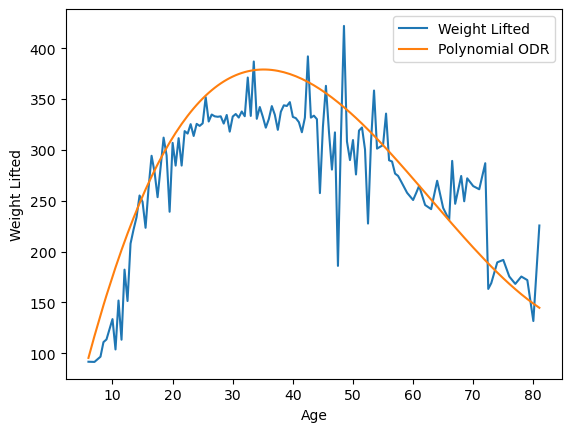

In [66]:
pord(total,'F',3)

Peak Mean Weight Lifted is at: 36.0 years old.
Recovered equation: y=67.46x + 41.24, t=0.67, p=5.06e-01
R_Squared: 0.8213506054575809


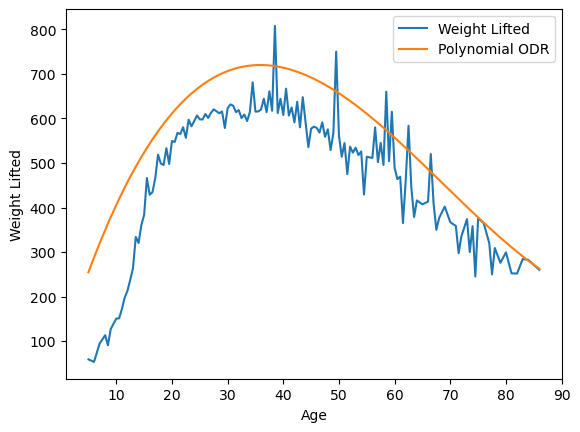

In [67]:
pord(total,'M',3)

Squat

Peak Mean Weight Lifted is at: 35.5 years old.
Recovered equation: y=-38.63x + 10.85, t=-2.30, p=2.33e-02
R_Squared: 0.806314570614688


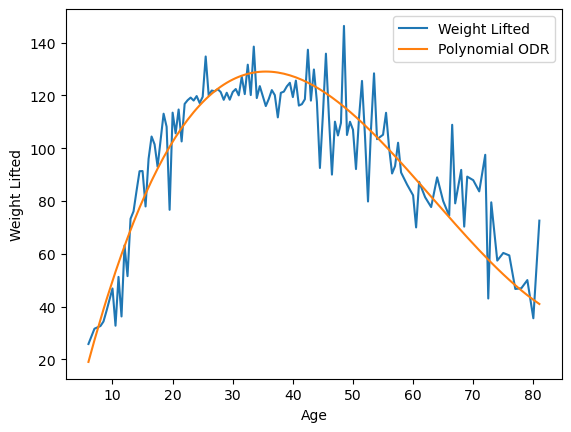

In [68]:
pord(squat,'F',3)

Peak Mean Weight Lifted is at: 35.5 years old.
Recovered equation: y=-175.35x + 28.05, t=-4.45, p=1.78e-05
R_Squared: 0.8055607976348467


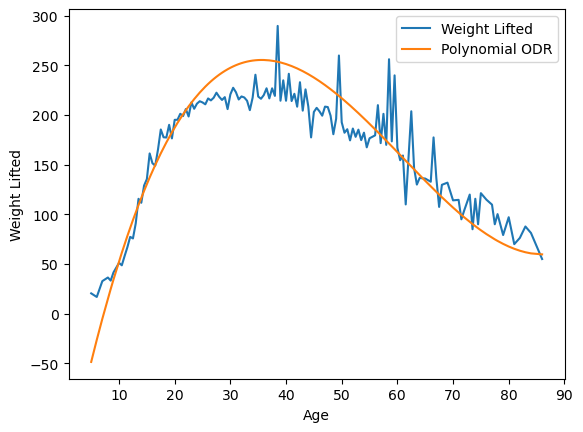

In [69]:
pord(squat,'M',3)

Bench

Peak Mean Weight Lifted is at: 39.0 years old.
Recovered equation: y=-18.71x + 5.61, t=-2.29, p=2.35e-02
R_Squared: 0.828416799024492


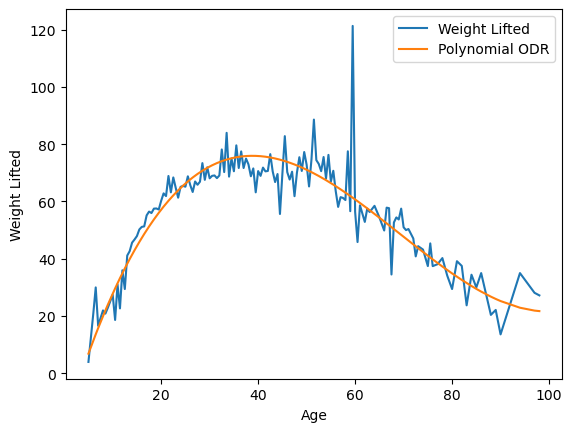

In [70]:
pord(bench,'F',3)

Peak Mean Weight Lifted is at: 40.0 years old.
Recovered equation: y=-46.83x + 12.44, t=-4.56, p=1.00e-05
R_Squared: 0.9327387211667745


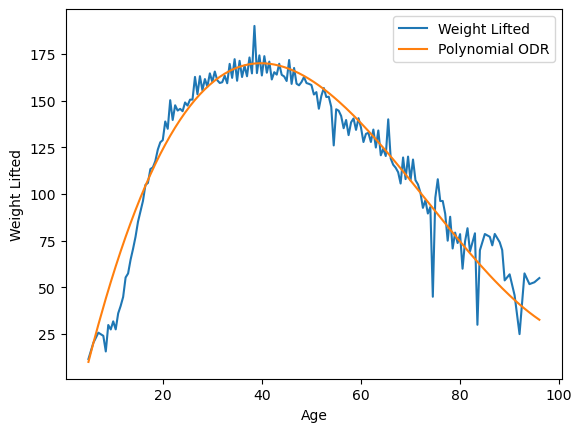

In [71]:
pord(bench,'M',3)

Deadlift

Peak Mean Weight Lifted is at: 38.0 years old.
Recovered equation: y=-12.53x + 9.84, t=-1.06, p=2.93e-01
R_Squared: 0.875815963352165


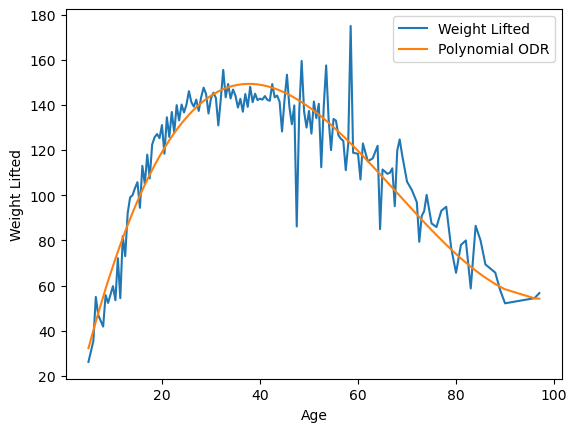

In [72]:
pord(dead,'F',3)

Peak Mean Weight Lifted is at: 37.5 years old.
Recovered equation: y=-92.67x + 21.57, t=-3.28, p=1.29e-03
R_Squared: 0.8736622633467599


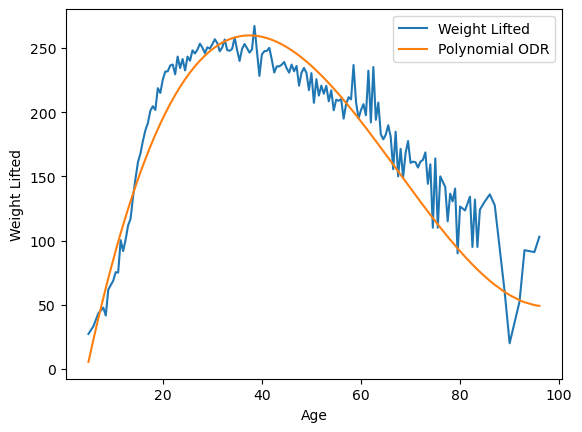

In [73]:
pord(dead,'M',3)

# Export Drug Tested Top Strength Population

Export the dataframe consisting of top 10% strength for each weight group

In [74]:
max_strength_df(total,'M').to_pickle('NDT_Total_M.pkl')
max_strength_df(squat,'M').to_pickle('NDT_Squat_M.pkl')
max_strength_df(bench,'M').to_pickle('NDT_Bench_M.pkl')
max_strength_df(dead,'M').to_pickle('NDT_Dead_M.pkl')

max_strength_df(total,'F').to_pickle('NDT_Total_F.pkl')
max_strength_df(squat,'F').to_pickle('NDT_Squat_F.pkl')
max_strength_df(bench,'F').to_pickle('NDT_Bench_F.pkl')
max_strength_df(dead,'F').to_pickle('NDT_Dead_F.pkl')